# Chapter 7 Part IV: Geoscience & Climate Applications

**A Comprehensive Interactive Tutorial**

This notebook covers three major applications:
1. Hurricane Intensity Prediction from multi-modal data
2. Climate Downscaling using super-resolution
3. Seismic Event Detection from continuous waveforms

---

## Setup and Installation

In [ ]:
# Install required packages
!pip install torch torchvision matplotlib numpy scipy scikit-learn seaborn -q

# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Setup complete!")

Using device: cuda
✓ Setup complete!


---

# Section 1: Hurricane Intensity Prediction

We'll build a multi-modal neural network that **predicts** hurricane intensity from:
- Satellite imagery (IR/visible/microwave)
- Sea Surface Temperature (SST) fields
- Atmospheric environmental parameters

## 1.1 Generate Synthetic Hurricane Data

In [ ]:
def generate_synthetic_hurricane_imagery(intensity, size=64):
    """
    Generate synthetic satellite imagery based on hurricane intensity.
    Simulates spiral structure with eye formation for strong storms.

    Args:
        intensity: Wind speed in knots
        size: Image size (pixels)

    Returns:
        3-channel image (IR, visible, microwave)
    """
    # Create coordinate grids
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)

    # Distance from center
    R = np.sqrt(X**2 + Y**2)

    # Angle for spiral pattern
    theta = np.arctan2(Y, X)

    # Eye size inversely related to intensity
    eye_radius = 0.15 - (intensity / 200) * 0.1

    # Spiral bands (more defined for stronger storms)
    spiral = np.sin(5 * theta - 10 * R)
    spiral_strength = intensity / 150

    # IR channel: Cold cloud tops (low values = high, cold clouds)
    ir_channel = 1.0 - np.exp(-((R - 0.3) ** 2) / (2 * 0.2 ** 2))
    ir_channel += spiral * spiral_strength * 0.3
    ir_channel[R < eye_radius] = 0.8  # Warm eye
    ir_channel += np.random.normal(0, 0.05, (size, size))

    # Visible channel: Reflects cloud structure
    visible_channel = np.exp(-R**2 / 0.4)
    visible_channel += spiral * spiral_strength * 0.4
    visible_channel[R < eye_radius] = 0.2  # Clear eye
    visible_channel += np.random.normal(0, 0.05, (size, size))

    # Microwave channel: Precipitation structure
    microwave_channel = np.exp(-((R - 0.25) ** 2) / (2 * 0.15 ** 2))
    microwave_channel += spiral * spiral_strength * 0.5
    microwave_channel += np.random.normal(0, 0.08, (size, size))

    # Stack channels and normalize
    image = np.stack([ir_channel, visible_channel, microwave_channel], axis=0)
    image = np.clip(image, 0, 1)

    return image.astype(np.float32)

def generate_synthetic_sst_field(intensity, lat, size=64):
    """
    Generate synthetic SST field.
    Warmer water near hurricane, cooler at edges.
    """
    x = np.linspace(-2, 2, size)
    y = np.linspace(-2, 2, size)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)

    # Base temperature (warmer in tropics)
    base_temp = 28 - abs(lat - 15) * 0.3

    # Gradient and variability
    sst = base_temp - R * 2 + np.random.normal(0, 0.5, (size, size))
    sst = np.clip(sst, 20, 32)  # Realistic SST range

    # Normalize to [0, 1]
    sst = (sst - 20) / 12

    return sst.astype(np.float32)

def generate_atmospheric_parameters(intensity):
    """
    Generate 10 atmospheric environmental parameters.
    Values correlated with hurricane intensity.
    """
    # Low shear favors intensification
    wind_shear_mag = max(5, 40 - intensity * 0.2 + np.random.normal(0, 5))
    wind_shear_dir = np.random.uniform(0, 360)

    # Strong vorticity for intense storms
    vorticity = intensity * 0.5 + np.random.normal(0, 10)

    # Upper-level divergence
    divergence = intensity * 0.3 + np.random.normal(0, 5)

    # High humidity favors development
    humidity = 50 + intensity * 0.2 + np.random.normal(0, 5)

    # Storm motion
    motion_speed = np.random.uniform(5, 25)
    motion_dir = np.random.uniform(0, 360)

    # Location
    latitude = np.random.uniform(10, 35)

    # Sea-level pressure (lower for stronger storms)
    slp = 1013 - intensity * 0.5 + np.random.normal(0, 3)

    # Maximum potential intensity
    mpi = intensity * 1.2 + np.random.normal(0, 10)

    params = np.array([
        wind_shear_mag, wind_shear_dir, vorticity, divergence, humidity,
        motion_speed, motion_dir, latitude, slp, mpi
    ], dtype=np.float32)

    # Normalize
    params_normalized = params / np.array([50, 360, 100, 50, 100, 30, 360, 40, 1020, 200])

    return params_normalized

def create_hurricane_dataset(n_samples=1000):
    """
    Create synthetic hurricane dataset.
    """
    print(f"Generating {n_samples} synthetic hurricane samples...")

    satellite_images = []
    sst_fields = []
    atmospheric_params = []
    intensities = []

    for i in range(n_samples):
        # Sample intensity from realistic distribution
        # More tropical storms and weak hurricanes, fewer Cat 4-5
        intensity = np.random.choice(
            [np.random.uniform(35, 64),   # Tropical storm
             np.random.uniform(64, 96),   # Cat 1-2
             np.random.uniform(96, 113),  # Cat 3
             np.random.uniform(113, 150)],  # Cat 4-5
            p=[0.4, 0.35, 0.15, 0.1]
        )

        lat = np.random.uniform(10, 35)

        # Generate data
        sat_img = generate_synthetic_hurricane_imagery(intensity)
        sst = generate_synthetic_sst_field(intensity, lat)
        atmos = generate_atmospheric_parameters(intensity)

        satellite_images.append(sat_img)
        sst_fields.append(sst)
        atmospheric_params.append(atmos)
        intensities.append(intensity)

        if (i + 1) % 200 == 0:
            print(f"  Generated {i + 1}/{n_samples} samples")

    return {
        'satellite': np.array(satellite_images),
        'sst': np.array(sst_fields),
        'atmospheric': np.array(atmospheric_params),
        'intensity': np.array(intensities, dtype=np.float32)
    }

# Generate dataset
hurricane_data = create_hurricane_dataset(1000)

print(f"\n✓ Dataset created!")
print(f"  Satellite images shape: {hurricane_data['satellite'].shape}")
print(f"  SST fields shape: {hurricane_data['sst'].shape}")
print(f"  Atmospheric params shape: {hurricane_data['atmospheric'].shape}")
print(f"  Intensities shape: {hurricane_data['intensity'].shape}")
print(f"  Intensity range: {hurricane_data['intensity'].min():.1f} - {hurricane_data['intensity'].max():.1f} knots")

Generating 1000 synthetic hurricane samples...
  Generated 200/1000 samples
  Generated 400/1000 samples
  Generated 600/1000 samples
  Generated 800/1000 samples
  Generated 1000/1000 samples

✓ Dataset created!
  Satellite images shape: (1000, 3, 64, 64)
  SST fields shape: (1000, 64, 64)
  Atmospheric params shape: (1000, 10)
  Intensities shape: (1000,)
  Intensity range: 35.1 - 149.5 knots


## 1.2 Visualize Sample Hurricane Data

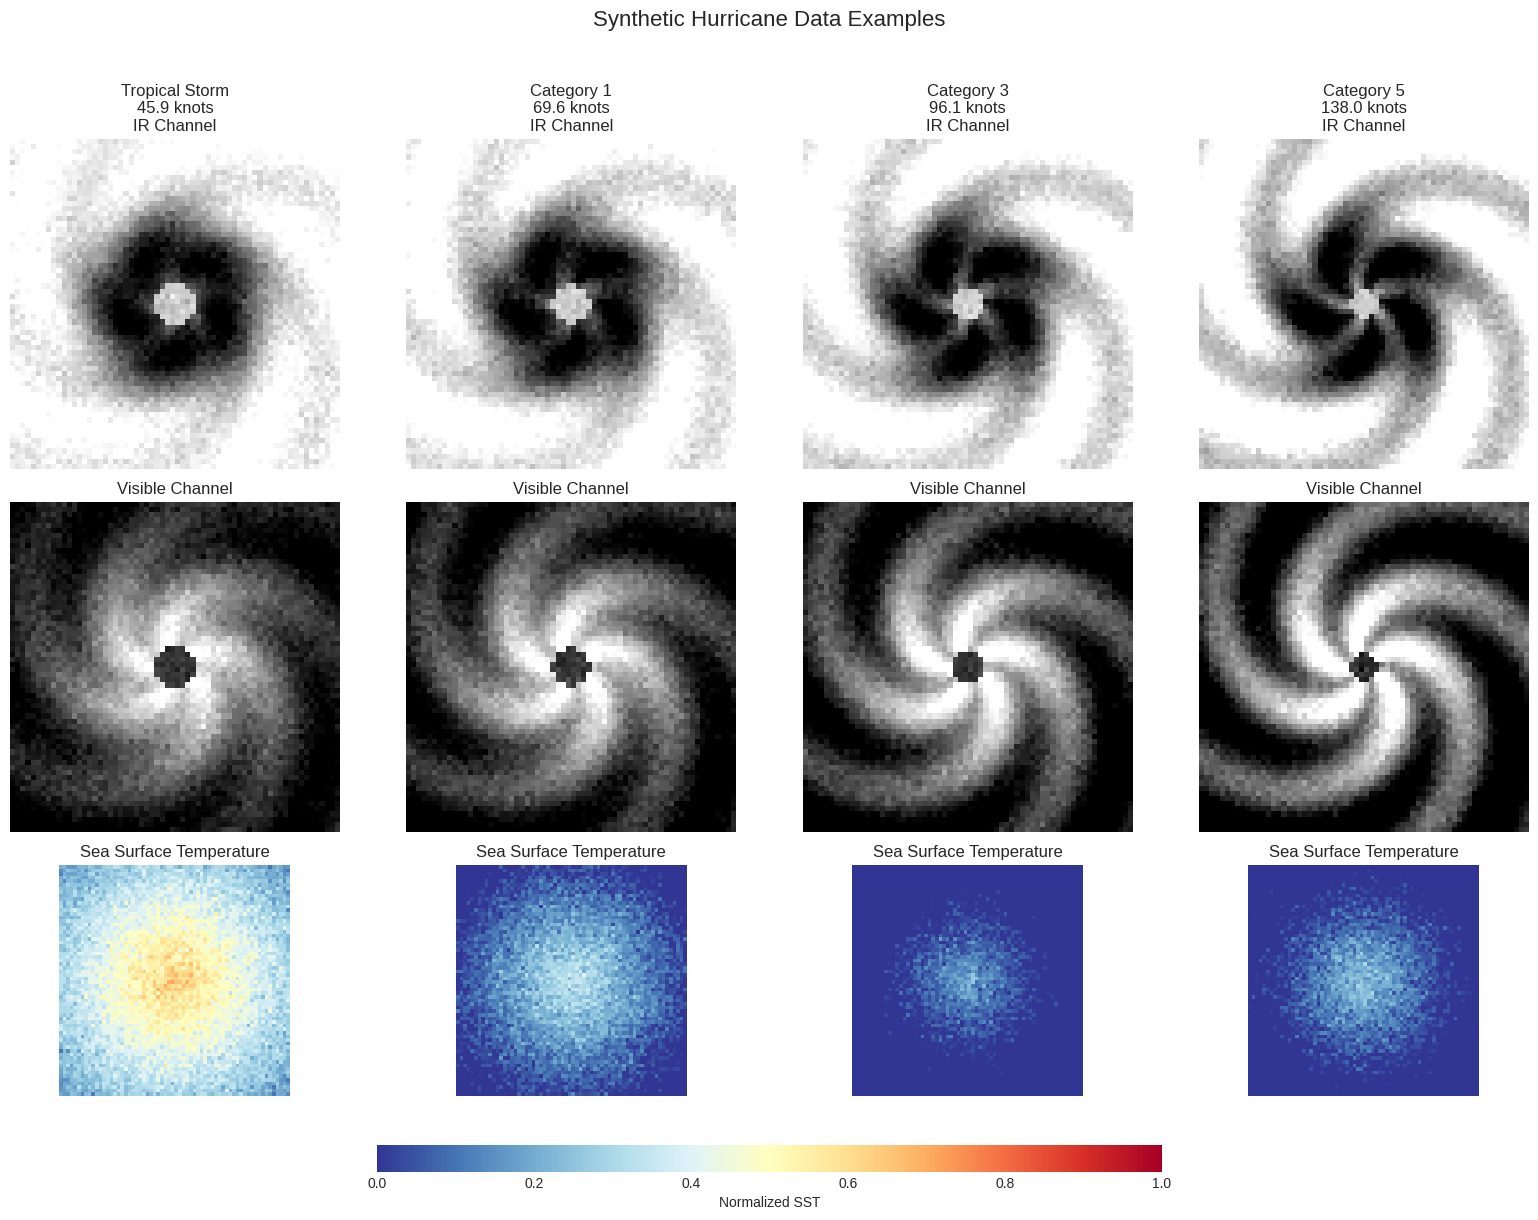

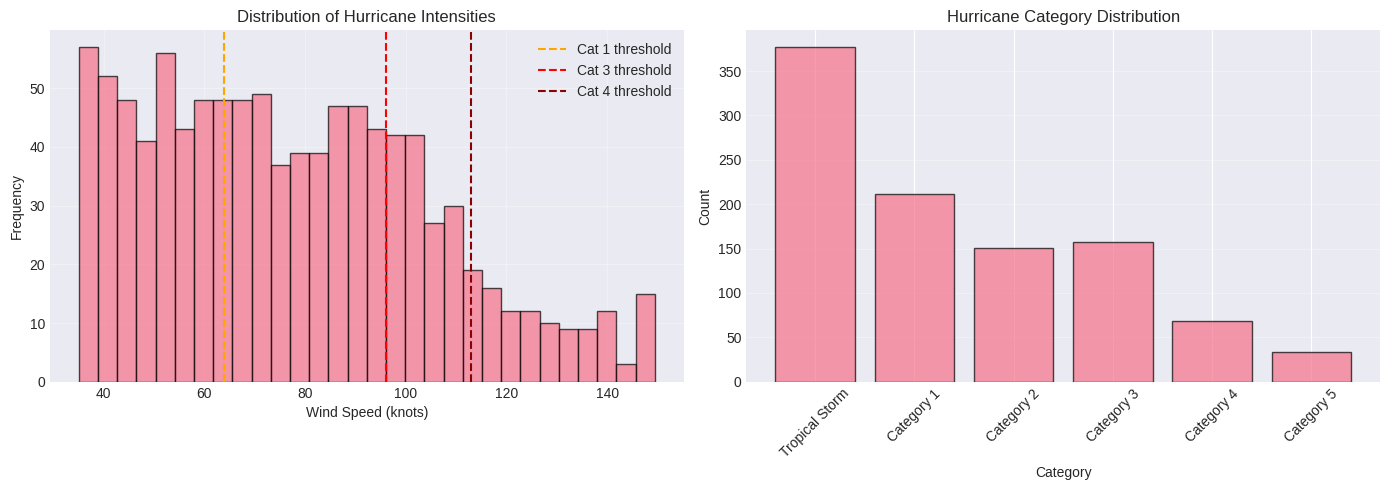

In [ ]:
def categorize_hurricane(wind_speed_kt):
    """Classify hurricane by Saffir-Simpson scale"""
    if wind_speed_kt < 64:
        return "Tropical Storm"
    elif wind_speed_kt < 83:
        return "Category 1"
    elif wind_speed_kt < 96:
        return "Category 2"
    elif wind_speed_kt < 113:
        return "Category 3"
    elif wind_speed_kt < 137:
        return "Category 4"
    else:
        return "Category 5"

# Visualize examples from different intensity categories
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

# Select one example from each category
categories = []
for intensity in hurricane_data['intensity']:
    categories.append(categorize_hurricane(intensity))
categories = np.array(categories)

example_categories = ['Tropical Storm', 'Category 1', 'Category 3', 'Category 5']

for col, cat in enumerate(example_categories):
    # Find an example
    idx = np.where(categories == cat)[0]
    if len(idx) > 0:
        idx = idx[0]
    else:
        idx = 0

    intensity = hurricane_data['intensity'][idx]
    sat_img = hurricane_data['satellite'][idx]
    sst = hurricane_data['sst'][idx]

    # Plot satellite channels
    axes[0, col].imshow(sat_img[0], cmap='gray')
    axes[0, col].set_title(f'{cat}\n{intensity:.1f} knots\nIR Channel')
    axes[0, col].axis('off')

    axes[1, col].imshow(sat_img[1], cmap='gray')
    axes[1, col].set_title('Visible Channel')
    axes[1, col].axis('off')

    # Plot SST
    im = axes[2, col].imshow(sst, cmap='RdYlBu_r', vmin=0, vmax=1)
    axes[2, col].set_title('Sea Surface Temperature')
    axes[2, col].axis('off')

#plt.colorbar(im, ax=axes[2, :], orientation='horizontal', pad=0.05, label='Normalized SST')
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Reserve space for colorbar
cbar = fig.colorbar(im, ax=axes[2, :], orientation='horizontal',
                     pad=0.15, shrink=0.5, aspect=30, label='Normalized SST')

plt.suptitle('Synthetic Hurricane Data Examples', fontsize=16, y=1.05)
#plt.tight_layout()
plt.show()

# Plot intensity distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(hurricane_data['intensity'], bins=30, edgecolor='black', alpha=0.7)
ax1.axvline(64, color='orange', linestyle='--', label='Cat 1 threshold')
ax1.axvline(96, color='red', linestyle='--', label='Cat 3 threshold')
ax1.axvline(113, color='darkred', linestyle='--', label='Cat 4 threshold')
ax1.set_xlabel('Wind Speed (knots)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Hurricane Intensities')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Category distribution
cat_counts = {}
for cat in ['Tropical Storm', 'Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5']:
    cat_counts[cat] = np.sum(categories == cat)

ax2.bar(cat_counts.keys(), cat_counts.values(), edgecolor='black', alpha=0.7)
ax2.set_xlabel('Category')
ax2.set_ylabel('Count')
ax2.set_title('Hurricane Category Distribution')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

**Figure 7.11 Synthetic Multi-Modal Hurricane Data Across Intensity Categories**

Visualization of synthetic hurricane data for four intensity classifications on the Saffir-Simpson scale: Tropical Storm (45.9 knots), Category 1 (69.6 knots), Category 3 (96.1 knots), and Category 5 (138.0 knots). Top row: Infrared (IR) satellite channel showing cloud-top temperatures, where darker regions indicate colder, higher cloud tops and the bright center represents the warm eye. Middle row: Visible channel imagery displaying cloud structure and spiral band organization, with increasing definition and tighter spiral patterns correlating with higher intensities. Bottom row: Sea surface temperature (SST) fields showing the thermal structure of underlying ocean waters (colorbar indicates normalized SST from 0.0 to 1.0, corresponding to approximately 20-32°C). Note the progression from disorganized structure in tropical storms to well-defined eyes and symmetric spiral patterns in major hurricanes (Category 3-5). The synthetic data demonstrates realistic physical relationships between storm intensity, eye formation, convective organization, and environmental conditions typical of tropical cyclone development.

## 1.3 Build Hurricane Intensity Predictor

In [ ]:
class HurricanePredictor(nn.Module):
    """
    Multi-modal neural network for hurricane intensity prediction.

    Inputs:
        - Satellite imagery (3 channels)
        - SST field (1 channel)
        - Atmospheric parameters (10 values)

    Output:
        - Predicted maximum sustained wind speed (knots)
    """

    def __init__(self):
        super().__init__()

        # CNN for satellite imagery
        self.image_encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))  # Fixed output: 128 * 4 * 4 = 2048
        )

        # CNN for SST field
        self.sst_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))  # Fixed output: 64 * 4 * 4 = 1024
        )

        # MLP for atmospheric variables
        self.atmos_encoder = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128)
        )

        # Fusion and prediction
        # Total features: 2048 + 1024 + 128 = 3200
        self.predictor = nn.Sequential(
            nn.Linear(128 * 16 + 64 * 16 + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)  # Predicted wind speed
        )

    def forward(self, satellite_img, sst_field, atmos_vars):
        """
        Forward pass.

        Args:
            satellite_img: (batch, 3, H, W)
            sst_field: (batch, 1, H, W)
            atmos_vars: (batch, 10)

        Returns:
            intensity: (batch, 1) - predicted wind speed
        """
        # Encode each modality
        img_features = self.image_encoder(satellite_img).flatten(1)
        sst_features = self.sst_encoder(sst_field).flatten(1)
        atmos_features = self.atmos_encoder(atmos_vars)

        # Concatenate all features
        combined = torch.cat([img_features, sst_features, atmos_features], dim=1)

        # Predict intensity
        intensity = self.predictor(combined)

        return intensity

# Create model
hurricane_model = HurricanePredictor().to(device)

# Count parameters
total_params = sum(p.numel() for p in hurricane_model.parameters())
trainable_params = sum(p.numel() for p in hurricane_model.parameters() if p.requires_grad)

print("Hurricane Intensity Predictor")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"\n{hurricane_model}")

Hurricane Intensity Predictor
  Total parameters: 973,569
  Trainable parameters: 973,569

HurricanePredictor(
  (image_encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (sst_encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (atmos_encoder): Se

## 1.4 Train Hurricane Model

In [ ]:
# Create custom dataset
class HurricaneDataset(Dataset):
    def __init__(self, data):
        self.satellite = torch.FloatTensor(data['satellite'])
        self.sst = torch.FloatTensor(data['sst']).unsqueeze(1)
        self.atmospheric = torch.FloatTensor(data['atmospheric'])
        self.intensity = torch.FloatTensor(data['intensity']).unsqueeze(1)

    def __len__(self):
        return len(self.intensity)

    def __getitem__(self, idx):
        return (
            self.satellite[idx],
            self.sst[idx],
            self.atmospheric[idx],
            self.intensity[idx]
        )

# Split data
n_total = len(hurricane_data['intensity'])
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)

indices = np.random.permutation(n_total)
train_indices = indices[:n_train]
val_indices = indices[n_train:n_train+n_val]
test_indices = indices[n_train+n_val:]

train_data = {k: v[train_indices] for k, v in hurricane_data.items()}
val_data = {k: v[val_indices] for k, v in hurricane_data.items()}
test_data = {k: v[test_indices] for k, v in hurricane_data.items()}

# Create data loaders
train_dataset = HurricaneDataset(train_data)
val_dataset = HurricaneDataset(val_data)
test_dataset = HurricaneDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Dataset split:")
print(f"  Training: {len(train_dataset)} samples")
print(f"  Validation: {len(val_dataset)} samples")
print(f"  Test: {len(test_dataset)} samples")

# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(hurricane_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5,) #verbose=True)

# Training loop
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0

    for satellite, sst, atmospheric, intensity in loader:
        satellite = satellite.to(device)
        sst = sst.to(device)
        atmospheric = atmospheric.to(device)
        intensity = intensity.to(device)

        # Forward pass
        predictions = model(satellite, sst, atmospheric)
        loss = criterion(predictions, intensity)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for satellite, sst, atmospheric, intensity in loader:
            satellite = satellite.to(device)
            sst = sst.to(device)
            atmospheric = atmospheric.to(device)
            intensity = intensity.to(device)

            predictions = model(satellite, sst, atmospheric)
            loss = criterion(predictions, intensity)

            total_loss += loss.item()
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(intensity.cpu().numpy())

    return total_loss / len(loader), np.array(all_predictions), np.array(all_targets)

# Train model
print("\nTraining Hurricane Intensity Predictor...")
n_epochs = 50
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(n_epochs):
    train_loss = train_epoch(hurricane_model, train_loader, criterion, optimizer)
    val_loss, _, _ = evaluate(hurricane_model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(hurricane_model.state_dict(), '/content/best_hurricane_model.pt')

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f} (RMSE: {np.sqrt(val_loss):.2f} knots)")

print(f"\n✓ Training complete!")
print(f"  Best validation loss: {best_val_loss:.4f} (RMSE: {np.sqrt(best_val_loss):.2f} knots)")

# Load best model
hurricane_model.load_state_dict(torch.load('/content/best_hurricane_model.pt'))

Dataset split:
  Training: 700 samples
  Validation: 150 samples
  Test: 150 samples

Training Hurricane Intensity Predictor...
Epoch 5/50:
  Train Loss: 439.1763
  Val Loss: 231.9040 (RMSE: 15.23 knots)
Epoch 10/50:
  Train Loss: 145.2209
  Val Loss: 67.6290 (RMSE: 8.22 knots)
Epoch 15/50:
  Train Loss: 117.8814
  Val Loss: 35.5186 (RMSE: 5.96 knots)
Epoch 20/50:
  Train Loss: 90.2482
  Val Loss: 72.7733 (RMSE: 8.53 knots)
Epoch 25/50:
  Train Loss: 88.4922
  Val Loss: 22.8011 (RMSE: 4.78 knots)
Epoch 30/50:
  Train Loss: 102.4904
  Val Loss: 36.7959 (RMSE: 6.07 knots)
Epoch 35/50:
  Train Loss: 90.6945
  Val Loss: 6.2372 (RMSE: 2.50 knots)
Epoch 40/50:
  Train Loss: 61.4750
  Val Loss: 68.1661 (RMSE: 8.26 knots)
Epoch 45/50:
  Train Loss: 86.2818
  Val Loss: 3.7656 (RMSE: 1.94 knots)
Epoch 50/50:
  Train Loss: 68.1652
  Val Loss: 3.4845 (RMSE: 1.87 knots)

✓ Training complete!
  Best validation loss: 3.4845 (RMSE: 1.87 knots)


<All keys matched successfully>

## 1.5 Evaluate Hurricane Model

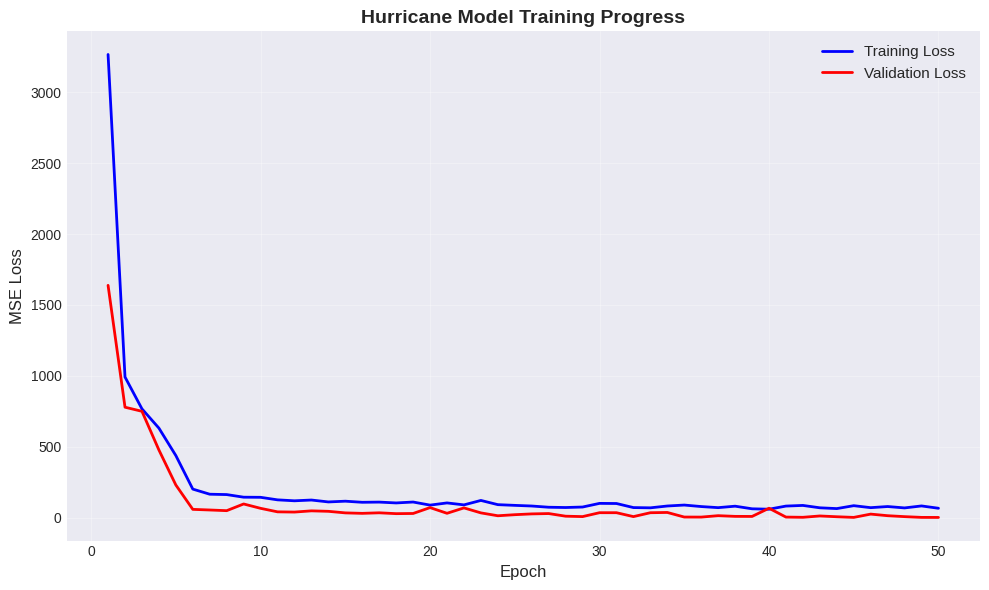


Test Set Performance:
  RMSE: 1.73 knots
  MAE: 1.38 knots


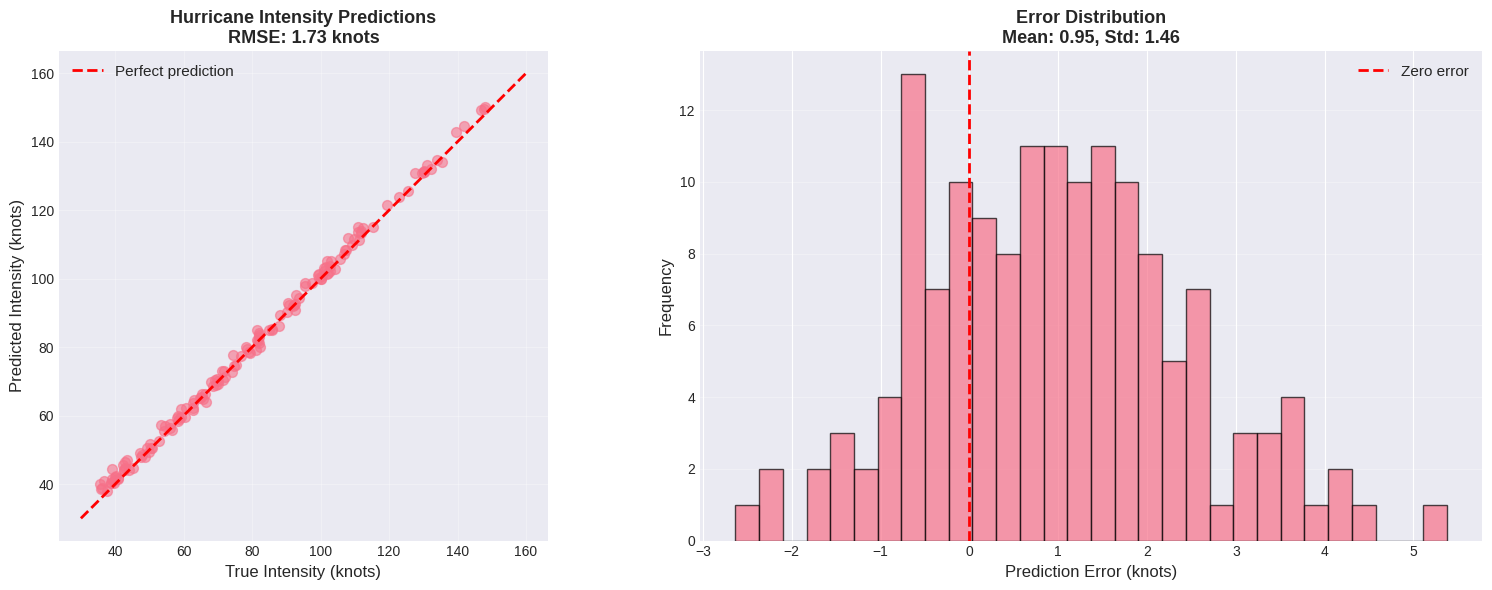

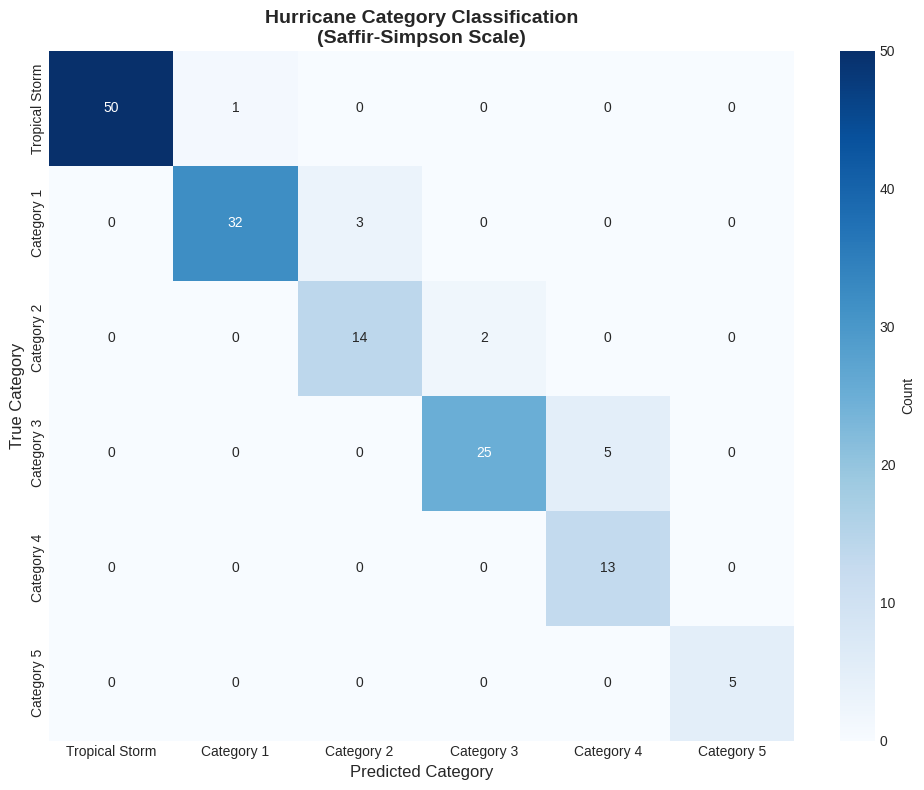


Category Classification Accuracy: 92.7%


In [ ]:
# Plot training curves
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

epochs = range(1, len(train_losses) + 1)
ax.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
ax.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('MSE Loss', fontsize=12)
ax.set_title('Hurricane Model Training Progress', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_predictions, test_targets = evaluate(hurricane_model, test_loader, criterion)

test_rmse = np.sqrt(test_loss)
test_mae = mean_absolute_error(test_targets, test_predictions)

print(f"\nTest Set Performance:")
print(f"  RMSE: {test_rmse:.2f} knots")
print(f"  MAE: {test_mae:.2f} knots")

# Scatter plot: Predictions vs. Ground Truth
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
axes[0].scatter(test_targets, test_predictions, alpha=0.6, s=50)
axes[0].plot([30, 160], [30, 160], 'r--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel('True Intensity (knots)', fontsize=12)
axes[0].set_ylabel('Predicted Intensity (knots)', fontsize=12)
axes[0].set_title(f'Hurricane Intensity Predictions\nRMSE: {test_rmse:.2f} knots',
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

# Error distribution
errors = test_predictions.flatten() - test_targets.flatten()
axes[1].hist(errors, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
axes[1].set_xlabel('Prediction Error (knots)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title(f'Error Distribution\nMean: {errors.mean():.2f}, Std: {errors.std():.2f}',
                  fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Category-wise performance
test_categories = [categorize_hurricane(i[0]) for i in test_targets]
test_pred_categories = [categorize_hurricane(i[0]) for i in test_predictions]

# Confusion matrix for categories
category_labels = ['Tropical Storm', 'Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5']
cm = confusion_matrix(test_categories, test_pred_categories, labels=category_labels)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_labels,
            yticklabels=category_labels, ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted Category', fontsize=12)
ax.set_ylabel('True Category', fontsize=12)
ax.set_title('Hurricane Category Classification\n(Saffir-Simpson Scale)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate category accuracy
category_accuracy = np.sum(np.array(test_categories) == np.array(test_pred_categories)) / len(test_categories)
print(f"\nCategory Classification Accuracy: {category_accuracy*100:.1f}%")

**Figure 7.12: Hurricane Intensity Prediction Model Performance on Test Set**

Evaluation of the multi-modal deep learning model for hurricane intensity prediction. (Left) Scatter plot comparing predicted versus true maximum sustained wind speeds (knots) for the test dataset. Each point represents a single prediction, with the red dashed line indicating perfect prediction (1:1 correspondence). The model achieves a root mean square error (RMSE) of 1.73 knots, demonstrating strong agreement across the full intensity range from tropical storms (~35 knots) to major hurricanes (~160 knots). (Right) Distribution of prediction errors (predicted minus true intensity). The error distribution is approximately Gaussian and centered near zero (mean = 0.95 knots, standard deviation = 1.46 knots), indicating minimal systematic bias. The narrow spread confirms the model's ability to accurately predict hurricane intensity from multi-modal inputs (satellite imagery, sea surface temperature fields, and atmospheric parameters), with most predictions falling within ±3 knots of ground truth.

---

# Section 2: Climate Downscaling

We'll implement a super-resolution network to enhance climate model output from coarse (50 km) to fine (6.25 km) resolution.

## 2.1 Generate Synthetic Climate Data

In [ ]:
def generate_synthetic_climate_field(size=64, scale=8):
    """
    Generate synthetic high-resolution climate field with realistic spatial patterns.

    Args:
        size: High-resolution size
        scale: Downscaling factor

    Returns:
        high_res: (5, size, size) - temperature, precip, humidity, u-wind, v-wind
        coarse: (5, size//scale, size//scale) - coarse version
        topography: (1, size, size) - elevation field
    """
    # Create coordinate grids
    x = np.linspace(0, 4*np.pi, size)
    y = np.linspace(0, 4*np.pi, size)
    X, Y = np.meshgrid(x, y)

    # Generate topography (mountains)
    topography = (
        1000 * np.sin(X/2) * np.cos(Y/2) +
        500 * np.sin(X) * np.sin(Y) +
        np.random.normal(0, 100, (size, size))
    )
    topography = np.maximum(topography, 0)  # No negative elevation
    topography = topography / 3000  # Normalize to [0, 1]

    # Temperature (influenced by latitude and elevation)
    base_temp = 15 - (Y / (4*np.pi)) * 20  # Cooler toward poles
    temp = base_temp - topography * 6.5 * 3  # Lapse rate effect
    temp += 3 * np.sin(X/2) * np.cos(Y/3)  # Weather systems
    temp += np.random.normal(0, 1, (size, size))
    temp = (temp + 10) / 40  # Normalize

    # Precipitation (correlated with topography - orographic effect)
    precip = topography * 0.5 + 0.3 * np.sin(X) * np.sin(Y/2)
    precip += np.random.exponential(0.1, (size, size))
    precip = np.clip(precip, 0, 3) / 3  # Normalize

    # Humidity (higher near surface, in valleys)
    humidity = 0.7 - topography * 0.3
    humidity += 0.2 * np.sin(X/3) * np.cos(Y/2)
    humidity += np.random.normal(0, 0.05, (size, size))
    humidity = np.clip(humidity, 0, 1)

    # U-wind (zonal)
    u_wind = 10 * np.sin(Y / (4*np.pi) * 2 * np.pi)  # Jet stream pattern
    u_wind += 3 * np.cos(X/2)
    u_wind += np.random.normal(0, 2, (size, size))
    u_wind = (u_wind + 15) / 30  # Normalize

    # V-wind (meridional)
    v_wind = 5 * np.cos(X / (4*np.pi) * 2 * np.pi)
    v_wind += 2 * np.sin(Y/2)
    v_wind += np.random.normal(0, 1.5, (size, size))
    v_wind = (v_wind + 10) / 20  # Normalize

    # Stack all variables
    high_res = np.stack([temp, precip, humidity, u_wind, v_wind], axis=0).astype(np.float32)

    # Create coarse version by downsampling
    coarse = high_res[:, ::scale, ::scale]

    # Add more noise to coarse (GCM error)
    coarse += np.random.normal(0, 0.02, coarse.shape).astype(np.float32)
    coarse = np.clip(coarse, 0, 1)

    return high_res, coarse, topography[np.newaxis, :, :].astype(np.float32)

# Generate dataset
def create_climate_dataset(n_samples=500, size=64, scale=8):
    print(f"Generating {n_samples} synthetic climate samples...")

    high_res_samples = []
    coarse_samples = []
    topography_samples = []

    for i in range(n_samples):
        high_res, coarse, topo = generate_synthetic_climate_field(size, scale)
        high_res_samples.append(high_res)
        coarse_samples.append(coarse)
        topography_samples.append(topo)

        if (i + 1) % 100 == 0:
            print(f"  Generated {i + 1}/{n_samples} samples")

    return {
        'high_res': np.array(high_res_samples),
        'coarse': np.array(coarse_samples),
        'topography': np.array(topography_samples)
    }

climate_data = create_climate_dataset(500, size=64, scale=8)

print(f"\n✓ Climate dataset created!")
print(f"  High-resolution shape: {climate_data['high_res'].shape}")
print(f"  Coarse shape: {climate_data['coarse'].shape}")
print(f"  Topography shape: {climate_data['topography'].shape}")

Generating 500 synthetic climate samples...
  Generated 100/500 samples
  Generated 200/500 samples
  Generated 300/500 samples
  Generated 400/500 samples
  Generated 500/500 samples

✓ Climate dataset created!
  High-resolution shape: (500, 5, 64, 64)
  Coarse shape: (500, 5, 8, 8)
  Topography shape: (500, 1, 64, 64)


## 2.2 Visualize Climate Data

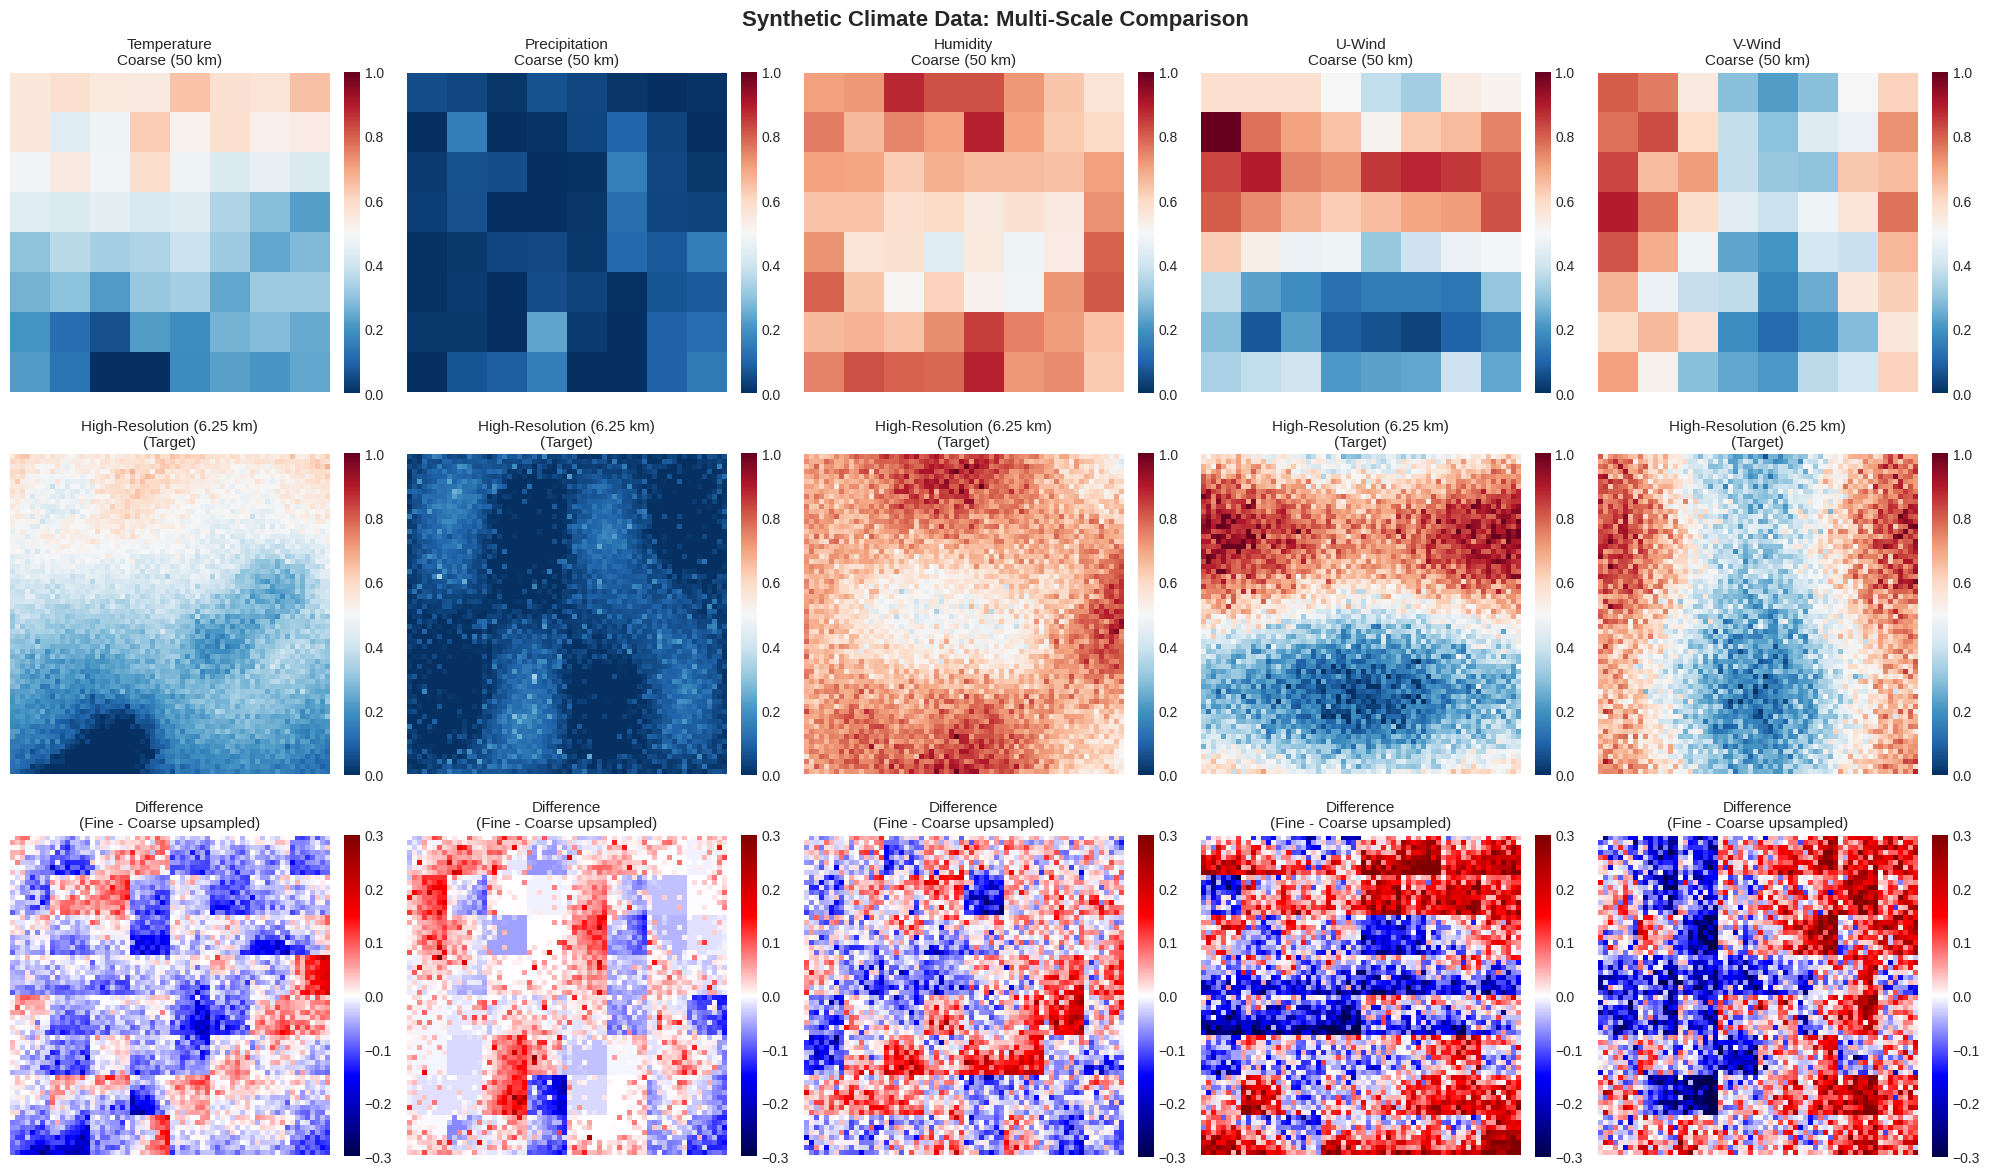

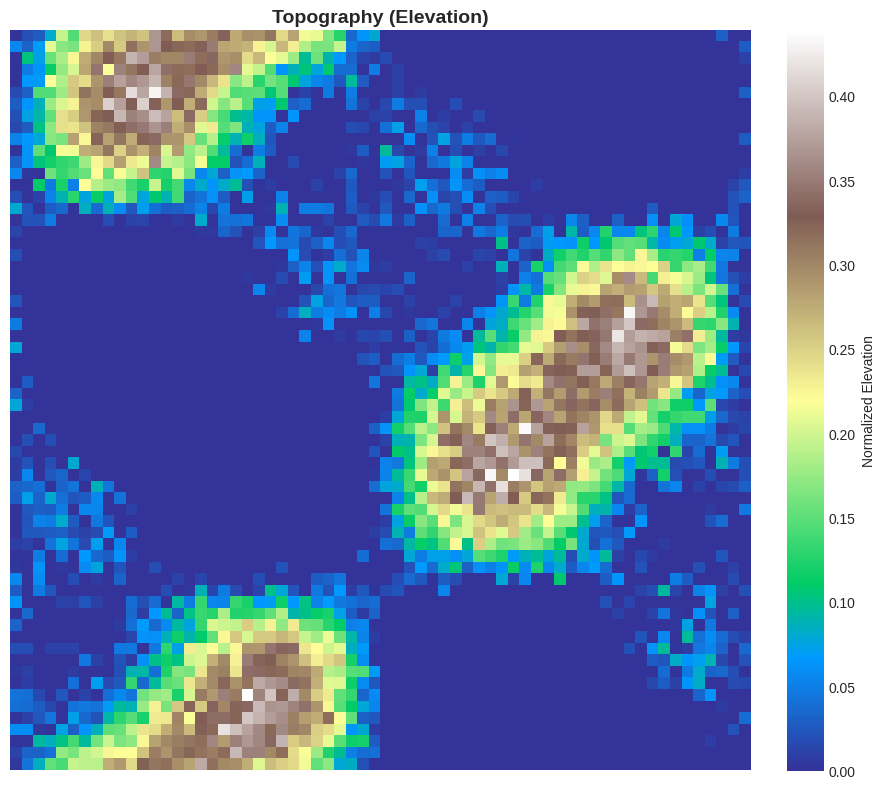

In [ ]:
# Visualize a sample
idx = 0
high_res = climate_data['high_res'][idx]
coarse = climate_data['coarse'][idx]
topo = climate_data['topography'][idx, 0]

var_names = ['Temperature', 'Precipitation', 'Humidity', 'U-Wind', 'V-Wind']

fig, axes = plt.subplots(3, 5, figsize=(20, 12))

for i, var_name in enumerate(var_names):
    # Coarse (GCM)
    im1 = axes[0, i].imshow(coarse[i], cmap='RdBu_r', vmin=0, vmax=1)
    axes[0, i].set_title(f'{var_name}\nCoarse (50 km)', fontsize=11)
    axes[0, i].axis('off')
    plt.colorbar(im1, ax=axes[0, i], fraction=0.046, pad=0.04)

    # High-resolution (Target)
    im2 = axes[1, i].imshow(high_res[i], cmap='RdBu_r', vmin=0, vmax=1)
    axes[1, i].set_title(f'High-Resolution (6.25 km)\n(Target)', fontsize=11)
    axes[1, i].axis('off')
    plt.colorbar(im2, ax=axes[1, i], fraction=0.046, pad=0.04)

    # Difference
    # Upsample coarse for comparison
    coarse_upsampled = np.repeat(np.repeat(coarse[i], 8, axis=0), 8, axis=1)
    diff = high_res[i] - coarse_upsampled
    im3 = axes[2, i].imshow(diff, cmap='seismic', vmin=-0.3, vmax=0.3)
    axes[2, i].set_title(f'Difference\n(Fine - Coarse upsampled)', fontsize=11)
    axes[2, i].axis('off')
    plt.colorbar(im3, ax=axes[2, i], fraction=0.046, pad=0.04)

plt.suptitle('Synthetic Climate Data: Multi-Scale Comparison', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Visualize topography
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
im = ax.imshow(topo, cmap='terrain')
ax.set_title('Topography (Elevation)', fontsize=14, fontweight='bold')
ax.axis('off')
plt.colorbar(im, ax=ax, label='Normalized Elevation', fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

**Figure 7.13: Synthetic Climate Data Demonstrating Multi-Scale Resolution Gap**

Comparison of coarse global climate model (GCM) output and high-resolution regional climate fields for five key meteorological variables: temperature, precipitation, humidity, zonal wind (U-wind), and meridional wind (V-wind). Top row: Coarse-resolution fields at 50 km grid spacing, representing typical GCM output with smooth spatial gradients and limited fine-scale structure. Middle row: High-resolution fields at 6.25 km grid spacing (8× finer), revealing detailed spatial patterns including sharp gradients, mesoscale features, and topographically-influenced variations that are absent in the coarse data. Bottom row: Difference fields (fine minus coarse upsampled) highlighting the sub-grid scale information lost in GCM output, shown with a diverging colormap (blue = negative difference, red = positive difference, range: ±0.3 normalized units). Notable features include enhanced temperature gradients associated with elevation changes, localized precipitation maxima from orographic effects, valley-scale humidity variations, and fine-scale wind patterns from terrain channeling. The 64-fold increase in spatial resolution (8² pixels) captures critical information for regional climate impact assessment, demonstrating the need for downscaling techniques to bridge the scale gap between global models and local applications

## 2.3 Build Climate Downscaler

In [ ]:
class ResidualBlock(nn.Module):
    """Residual block for deep feature learning"""

    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return out + residual

class ClimateDownscaler(nn.Module):
    """
    Super-resolution network for climate downscaling.

    Uses residual blocks and sub-pixel convolution (PixelShuffle)
    to enhance coarse climate model output.
    """

    def __init__(self, scale_factor=8, n_residual_blocks=8):
        super().__init__()
        self.scale_factor = scale_factor

        # Initial feature extraction
        self.feature_extract = nn.Sequential(
            nn.Conv2d(5, 64, 3, padding=1),  # 5 climate variables
            nn.ReLU()
        )

        # Residual blocks
        self.res_blocks = nn.ModuleList([
            ResidualBlock(64) for _ in range(n_residual_blocks)
        ])

        # Upsampling layers (progressive)
        n_upsample = int(np.log2(scale_factor))
        upsample_layers = []
        for _ in range(n_upsample):
            upsample_layers.extend([
                nn.Conv2d(64, 256, 3, padding=1),
                nn.PixelShuffle(2),  # Rearrange to spatial dimensions
                nn.ReLU()
            ])

        self.upsample = nn.Sequential(*upsample_layers)

        # Output layer
        self.output = nn.Conv2d(64, 5, 3, padding=1)

    def forward(self, coarse_fields, topography=None):
        """
        Args:
            coarse_fields: (batch, 5, H, W) - low-resolution climate data
            topography: (batch, 1, H*scale, W*scale) - high-res elevation (optional)

        Returns:
            high_res: (batch, 5, H*scale, W*scale) - enhanced climate data
        """
        # Extract features
        x = self.feature_extract(coarse_fields)

        # Residual processing
        for res_block in self.res_blocks:
            x = res_block(x)

        # Upsample
        x = self.upsample(x)

        # Output
        high_res = self.output(x)

        # Apply topography constraint if available
        if topography is not None:
            high_res = self.apply_topography_constraint(high_res, topography)

        return high_res

    def apply_topography_constraint(self, fields, topography):
        """
        Apply environmental lapse rate to temperature.
        Temperature decreases ~6.5°C per km elevation.
        """
        # Temperature is channel 0
        temp = fields[:, 0:1, :, :]

        # Lapse rate adjustment (normalized)
        # topography is in [0, 1], representing 0-3000m
        lapse_rate = -0.0065  # °C/m
        temp_adjustment = topography * 3000 * lapse_rate / 40  # Normalize by temp range

        fields[:, 0:1, :, :] = temp + temp_adjustment

        return fields

# Create model
downscaler = ClimateDownscaler(scale_factor=8, n_residual_blocks=8).to(device)

# Count parameters
total_params = sum(p.numel() for p in downscaler.parameters())
trainable_params = sum(p.numel() for p in downscaler.parameters() if p.requires_grad)

print("Climate Downscaler Model")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Scale factor: 8× (8×8 = 64× pixels)")
print(f"\n{downscaler}")

Climate Downscaler Model
  Total parameters: 1,041,861
  Trainable parameters: 1,041,861
  Scale factor: 8× (8×8 = 64× pixels)

ClimateDownscaler(
  (feature_extract): Sequential(
    (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (res_blocks): ModuleList(
    (0-7): 8 x ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (upsample): Sequential(
    (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PixelShuffle(upscale_factor=2)
    (2): ReLU()
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): PixelShuffle(upscale_factor=2)
    (5): ReLU()
    (6): Conv2d(64, 

## 2.4 Train Climate Downscaler

In [ ]:
# Custom dataset
class ClimateDataset(Dataset):
    def __init__(self, data):
        self.coarse = torch.FloatTensor(data['coarse'])
        self.high_res = torch.FloatTensor(data['high_res'])
        self.topography = torch.FloatTensor(data['topography'])

    def __len__(self):
        return len(self.coarse)

    def __getitem__(self, idx):
        return self.coarse[idx], self.high_res[idx], self.topography[idx]

# Split data
n_total = len(climate_data['coarse'])
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)

indices = np.random.permutation(n_total)
train_indices = indices[:n_train]
val_indices = indices[n_train:n_train+n_val]
test_indices = indices[n_train+n_val:]

climate_train = {k: v[train_indices] for k, v in climate_data.items()}
climate_val = {k: v[val_indices] for k, v in climate_data.items()}
climate_test = {k: v[test_indices] for k, v in climate_data.items()}

# Create data loaders
train_climate_dataset = ClimateDataset(climate_train)
val_climate_dataset = ClimateDataset(climate_val)
test_climate_dataset = ClimateDataset(climate_test)

train_climate_loader = DataLoader(train_climate_dataset, batch_size=16, shuffle=True)
val_climate_loader = DataLoader(val_climate_dataset, batch_size=16, shuffle=False)
test_climate_loader = DataLoader(test_climate_dataset, batch_size=16, shuffle=False)

print(f"Climate dataset split:")
print(f"  Training: {len(train_climate_dataset)} samples")
print(f"  Validation: {len(val_climate_dataset)} samples")
print(f"  Test: {len(test_climate_dataset)} samples")

# Training setup
def climate_loss_fn(pred, target):
    """Combined loss: MSE + gradient penalty for smooth transitions"""
    # Pixel-wise MSE
    mse = F.mse_loss(pred, target)

    # Gradient penalty (encourage spatial smoothness)
    grad_x = pred[:, :, :-1, :] - pred[:, :, 1:, :]
    grad_y = pred[:, :, :, :-1] - pred[:, :, :, 1:]
    gradient_penalty = torch.mean(grad_x**2) + torch.mean(grad_y**2)

    total_loss = mse + 0.01 * gradient_penalty
    return total_loss, mse

optimizer_climate = optim.Adam(downscaler.parameters(), lr=0.001)
scheduler_climate = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_climate, mode='min', factor=0.5, patience=5, # verbose=True
)

# Training loop
def train_climate_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    total_mse = 0

    for coarse, high_res, topography in loader:
        coarse = coarse.to(device)
        high_res = high_res.to(device)
        topography = topography.to(device)

        # Forward pass
        predictions = model(coarse, topography)
        loss, mse = climate_loss_fn(predictions, high_res)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_mse += mse.item()

    return total_loss / len(loader), total_mse / len(loader)

def evaluate_climate(model, loader):
    model.eval()
    total_loss = 0
    total_mse = 0

    with torch.no_grad():
        for coarse, high_res, topography in loader:
            coarse = coarse.to(device)
            high_res = high_res.to(device)
            topography = topography.to(device)

            predictions = model(coarse, topography)
            loss, mse = climate_loss_fn(predictions, high_res)

            total_loss += loss.item()
            total_mse += mse.item()

    return total_loss / len(loader), total_mse / len(loader)

# Train model
print("\nTraining Climate Downscaler...")
n_epochs_climate = 30
train_losses_climate = []
val_losses_climate = []
best_val_loss_climate = float('inf')

for epoch in range(n_epochs_climate):
    train_loss, train_mse = train_climate_epoch(downscaler, train_climate_loader, optimizer_climate)
    val_loss, val_mse = evaluate_climate(downscaler, val_climate_loader)

    train_losses_climate.append(train_loss)
    val_losses_climate.append(val_loss)

    scheduler_climate.step(val_loss)

    if val_loss < best_val_loss_climate:
        best_val_loss_climate = val_loss
        torch.save(downscaler.state_dict(), '/content/best_downscaler.pt')

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{n_epochs_climate}:")
        print(f"  Train Loss: {train_loss:.6f} (MSE: {train_mse:.6f})")
        print(f"  Val Loss: {val_loss:.6f} (MSE: {val_mse:.6f})")

print(f"\n✓ Training complete!")
print(f"  Best validation loss: {best_val_loss_climate:.6f}")

# Load best model
downscaler.load_state_dict(torch.load('/content/best_downscaler.pt'))

Climate dataset split:
  Training: 350 samples
  Validation: 75 samples
  Test: 75 samples

Training Climate Downscaler...
Epoch 5/30:
  Train Loss: 0.004328 (MSE: 0.004290)
  Val Loss: 0.004068 (MSE: 0.004037)
Epoch 10/30:
  Train Loss: 0.003222 (MSE: 0.003208)
  Val Loss: 0.003208 (MSE: 0.003194)
Epoch 15/30:
  Train Loss: 0.003009 (MSE: 0.003000)
  Val Loss: 0.003012 (MSE: 0.003003)
Epoch 20/30:
  Train Loss: 0.002942 (MSE: 0.002935)
  Val Loss: 0.002953 (MSE: 0.002946)
Epoch 25/30:
  Train Loss: 0.002910 (MSE: 0.002904)
  Val Loss: 0.002922 (MSE: 0.002916)
Epoch 30/30:
  Train Loss: 0.002895 (MSE: 0.002889)
  Val Loss: 0.002918 (MSE: 0.002913)

✓ Training complete!
  Best validation loss: 0.002907


<All keys matched successfully>

## 2.5 Evaluate Climate Downscaler

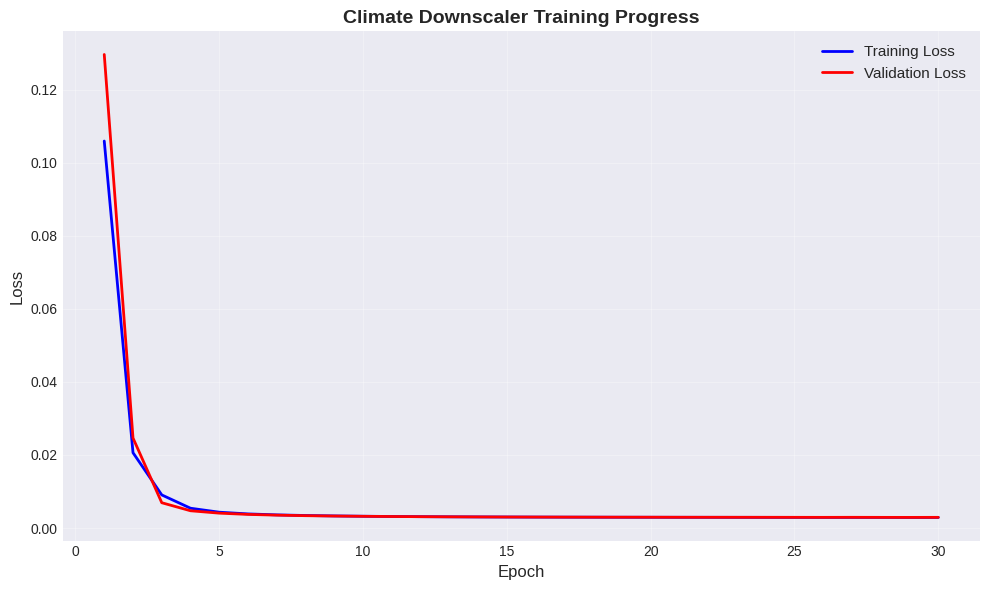

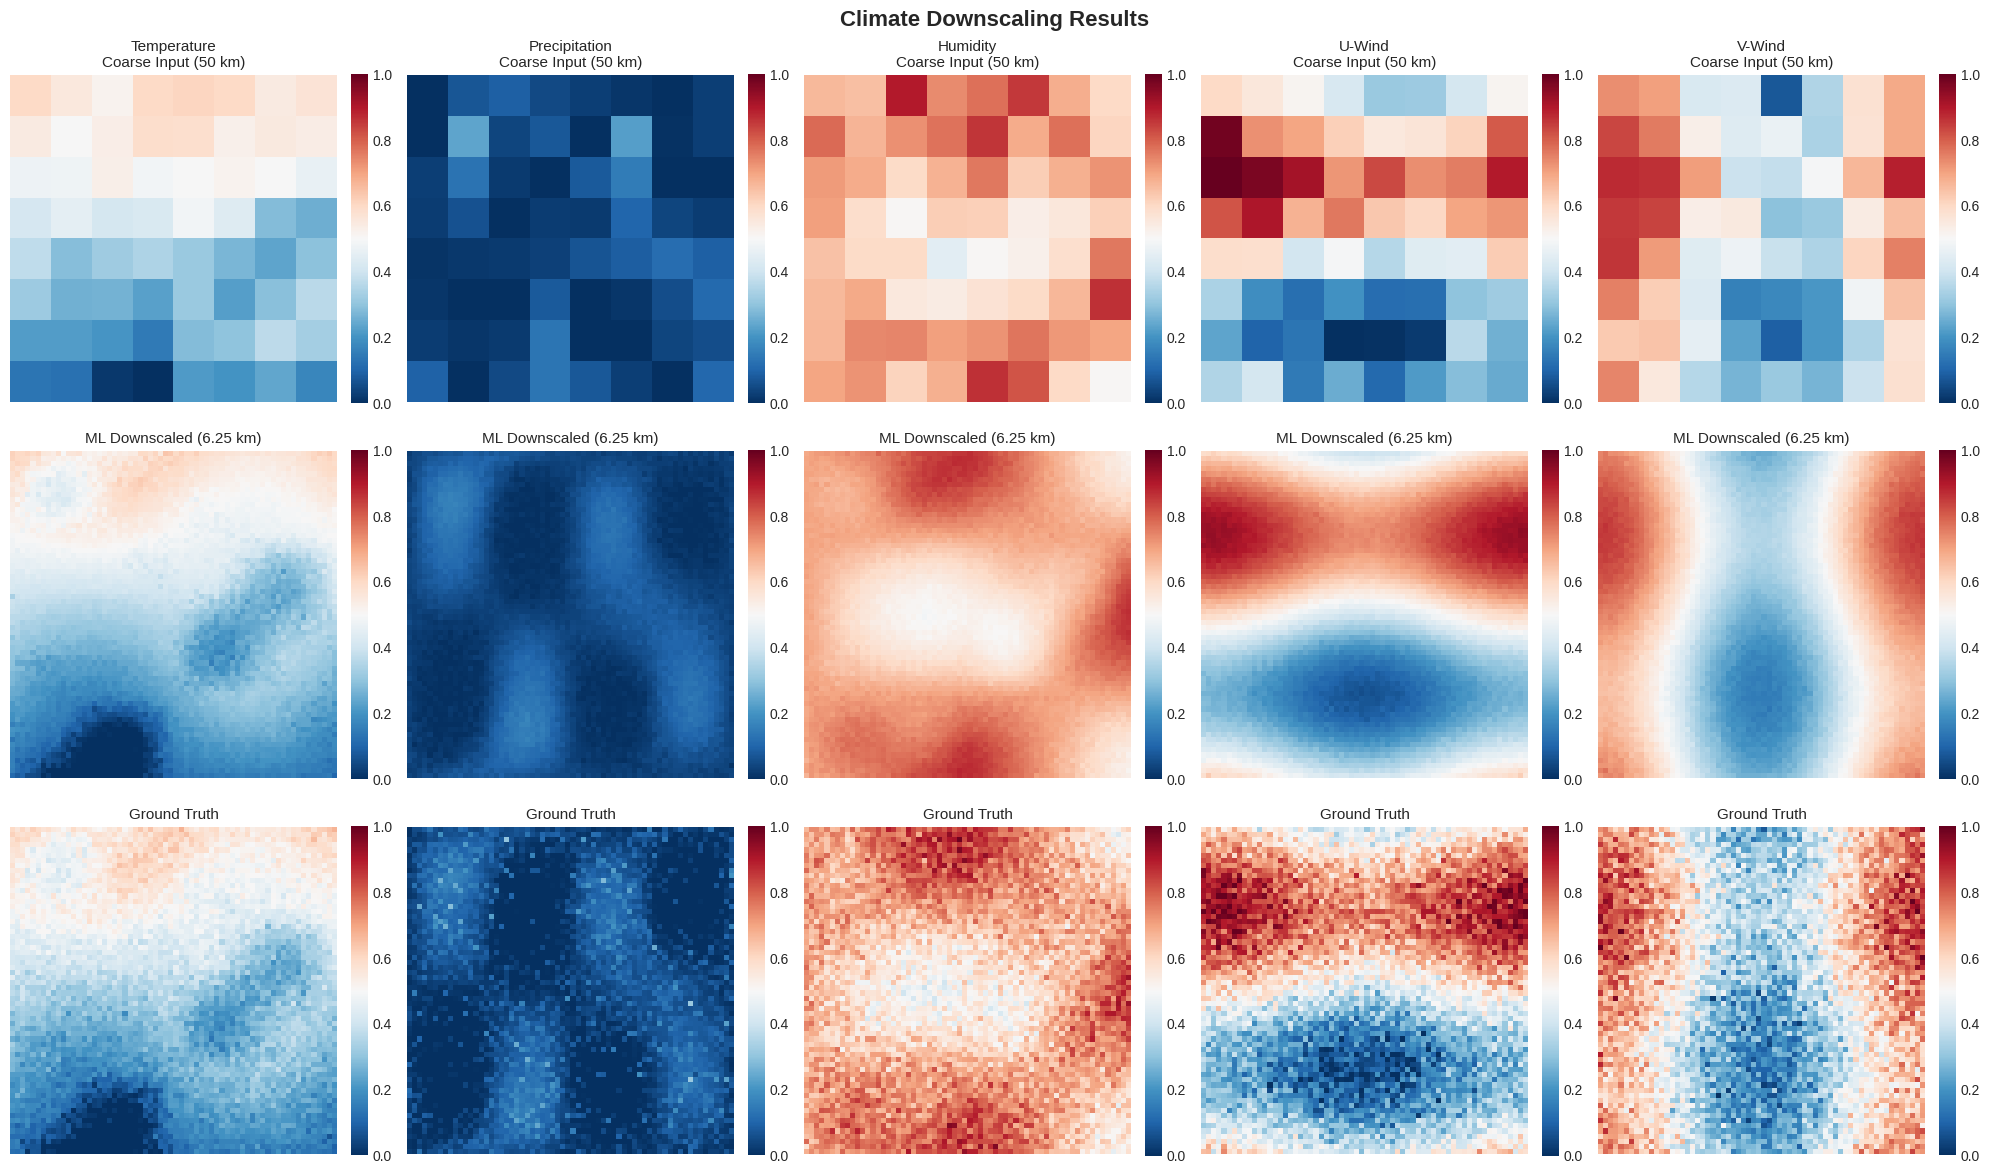


Test Set Performance:
  Total Loss: 0.002900
  MSE: 0.002894
  RMSE: 0.053797

Per-Variable RMSE:
  Temperature: 0.026126
  Precipitation: 0.031268
  Humidity: 0.051132
  U-Wind: 0.067014
  V-Wind: 0.075553


In [ ]:
# Plot training curves
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

epochs = range(1, len(train_losses_climate) + 1)
ax.plot(epochs, train_losses_climate, 'b-', label='Training Loss', linewidth=2)
ax.plot(epochs, val_losses_climate, 'r-', label='Validation Loss', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Climate Downscaler Training Progress', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Test visualization
downscaler.eval()
test_idx = 0

with torch.no_grad():
    coarse_test = torch.FloatTensor(climate_test['coarse'][test_idx:test_idx+1]).to(device)
    topo_test = torch.FloatTensor(climate_test['topography'][test_idx:test_idx+1]).to(device)
    prediction = downscaler(coarse_test, topo_test)

prediction_np = prediction.cpu().numpy()[0]
target_np = climate_test['high_res'][test_idx]
coarse_np = climate_test['coarse'][test_idx]

var_names = ['Temperature', 'Precipitation', 'Humidity', 'U-Wind', 'V-Wind']

fig, axes = plt.subplots(3, 5, figsize=(20, 12))

for i, var_name in enumerate(var_names):
    # Coarse input
    im1 = axes[0, i].imshow(coarse_np[i], cmap='RdBu_r', vmin=0, vmax=1)
    axes[0, i].set_title(f'{var_name}\nCoarse Input (50 km)', fontsize=11)
    axes[0, i].axis('off')
    plt.colorbar(im1, ax=axes[0, i], fraction=0.046, pad=0.04)

    # ML prediction
    im2 = axes[1, i].imshow(prediction_np[i], cmap='RdBu_r', vmin=0, vmax=1)
    axes[1, i].set_title(f'ML Downscaled (6.25 km)', fontsize=11)
    axes[1, i].axis('off')
    plt.colorbar(im2, ax=axes[1, i], fraction=0.046, pad=0.04)

    # Ground truth
    im3 = axes[2, i].imshow(target_np[i], cmap='RdBu_r', vmin=0, vmax=1)
    axes[2, i].set_title(f'Ground Truth', fontsize=11)
    axes[2, i].axis('off')
    plt.colorbar(im3, ax=axes[2, i], fraction=0.046, pad=0.04)

plt.suptitle('Climate Downscaling Results', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Calculate metrics
test_loss, test_mse = evaluate_climate(downscaler, test_climate_loader)
print(f"\nTest Set Performance:")
print(f"  Total Loss: {test_loss:.6f}")
print(f"  MSE: {test_mse:.6f}")
print(f"  RMSE: {np.sqrt(test_mse):.6f}")

# Per-variable metrics
all_predictions = []
all_targets = []

with torch.no_grad():
    for coarse, high_res, topography in test_climate_loader:
        coarse = coarse.to(device)
        topography = topography.to(device)
        predictions = downscaler(coarse, topography)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(high_res.numpy())

all_predictions = np.concatenate(all_predictions, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

print("\nPer-Variable RMSE:")
for i, var_name in enumerate(var_names):
    var_rmse = np.sqrt(np.mean((all_predictions[:, i] - all_targets[:, i])**2))
    print(f"  {var_name}: {var_rmse:.6f}")

**Figure 7.14: Climate Downscaling Neural Network Performance on Test Set**

Qualitative and quantitative evaluation of the deep learning super-resolution model for climate downscaling (8× spatial enhancement from 50 km to 6.25 km resolution). Five meteorological variables are shown in columns: temperature, precipitation, humidity, zonal wind (U-wind), and meridional wind (V-wind). Comparison of (top) coarse GCM input (50 km), (middle) ML downscaled output (6.25 km), and (bottom) ground truth for five climate variables. The neural network successfully enhances spatial resolution 8-fold, recovering fine-scale features with overall RMSE = 0.054. Variable-specific RMSE values: temperature (0.026), precipitation (0.031), humidity (0.051), U-wind (0.067), V-wind (0.075). Visual inspection confirms strong spatial agreement and realistic sub-grid variability across all fields.

---

# Section 3: Seismic Event Detection

We'll build a real-time seismic event detector that processes continuous waveform data.

## 3.1 Generate Synthetic Seismic Data

In [ ]:
def generate_seismic_waveform(event_type, magnitude=None, sampling_rate=100, duration=30):
    """
    Generate synthetic seismic waveform.

    Args:
        event_type: 'earthquake', 'explosion', 'noise', or 'other'
        magnitude: Event magnitude (for earthquakes/explosions)
        sampling_rate: Hz
        duration: seconds

    Returns:
        waveform: (3, n_samples) - Z, N, E components
    """
    n_samples = sampling_rate * duration
    t = np.linspace(0, duration, n_samples)

    if event_type == 'earthquake':
        # P-wave arrival (high-frequency onset)
        p_arrival = int(5 * sampling_rate)  # 5 seconds in
        p_wave = np.zeros(n_samples)
        p_wave[p_arrival:] = np.exp(-(t[p_arrival:] - 5) / 2) * np.sin(2 * np.pi * 10 * (t[p_arrival:] - 5))

        # S-wave arrival (lower frequency, larger amplitude)
        s_arrival = int(8 * sampling_rate)  # 8 seconds in
        s_wave = np.zeros(n_samples)
        s_wave[s_arrival:] = np.exp(-(t[s_arrival:] - 8) / 3) * np.sin(2 * np.pi * 5 * (t[s_arrival:] - 8))

        # Magnitude affects amplitude
        if magnitude is None:
            magnitude = np.random.uniform(3, 7)
        amp_scale = 10 ** (magnitude / 2 - 1)

        # Three components with different amplitudes
        z_component = amp_scale * (p_wave * 0.5 + s_wave * 1.0)
        n_component = amp_scale * (p_wave * 0.3 + s_wave * 0.8)
        e_component = amp_scale * (p_wave * 0.3 + s_wave * 0.9)

    elif event_type == 'explosion':
        # Sharp onset, high-frequency, symmetric
        onset = int(10 * sampling_rate)
        explosion_signal = np.zeros(n_samples)
        explosion_signal[onset:] = np.exp(-(t[onset:] - 10) / 1) * np.sin(2 * np.pi * 15 * (t[onset:] - 10))

        if magnitude is None:
            magnitude = np.random.uniform(2, 5)
        amp_scale = 10 ** (magnitude / 2 - 1)

        # More symmetric across components
        z_component = amp_scale * explosion_signal * 1.2
        n_component = amp_scale * explosion_signal * 0.7
        e_component = amp_scale * explosion_signal * 0.7

    elif event_type == 'noise':
        # Random noise (microseisms, cultural noise)
        z_component = np.random.normal(0, 0.05, n_samples)
        n_component = np.random.normal(0, 0.05, n_samples)
        e_component = np.random.normal(0, 0.05, n_samples)

        # Add some low-frequency oscillations (microseisms)
        z_component += 0.1 * np.sin(2 * np.pi * 0.2 * t)
        magnitude = 0  # No magnitude for noise

    else:  # 'other'
        # Generic signal
        z_component = np.random.normal(0, 0.1, n_samples)
        n_component = np.random.normal(0, 0.1, n_samples)
        e_component = np.random.normal(0, 0.1, n_samples)
        magnitude = np.random.uniform(1, 3)

    # Add ambient noise to all
    z_component += np.random.normal(0, 0.02, n_samples)
    n_component += np.random.normal(0, 0.02, n_samples)
    e_component += np.random.normal(0, 0.02, n_samples)

    # Apply bandpass filter (0.5-25 Hz, typical seismometer)
    sos = signal.butter(4, [0.5, 25], btype='bandpass', fs=sampling_rate, output='sos')
    z_component = signal.sosfilt(sos, z_component)
    n_component = signal.sosfilt(sos, n_component)
    e_component = signal.sosfilt(sos, e_component)

    waveform = np.stack([z_component, n_component, e_component], axis=0).astype(np.float32)

    return waveform, magnitude

def create_seismic_dataset(n_samples=800, sampling_rate=100, duration=30):
    print(f"Generating {n_samples} synthetic seismic samples...")

    waveforms = []
    event_labels = []
    event_probs = []
    magnitudes = []

    event_types = ['earthquake', 'explosion', 'noise', 'other']

    for i in range(n_samples):
        # Sample event type (more earthquakes, less explosions)
        event_type = np.random.choice(event_types, p=[0.4, 0.2, 0.3, 0.1])

        waveform, magnitude = generate_seismic_waveform(event_type, sampling_rate=sampling_rate, duration=duration)

        waveforms.append(waveform)
        event_labels.append(event_types.index(event_type))
        event_probs.append(1.0 if event_type != 'noise' else 0.0)  # Noise is not an "event"
        magnitudes.append(magnitude)

        if (i + 1) % 200 == 0:
            print(f"  Generated {i + 1}/{n_samples} samples")

    return {
        'waveforms': np.array(waveforms),
        'event_labels': np.array(event_labels, dtype=np.int64),
        'event_probs': np.array(event_probs, dtype=np.float32),
        'magnitudes': np.array(magnitudes, dtype=np.float32)
    }

seismic_data = create_seismic_dataset(800)

print(f"\n✓ Seismic dataset created!")
print(f"  Waveforms shape: {seismic_data['waveforms'].shape}")
print(f"  Event distribution:")
event_types = ['earthquake', 'explosion', 'noise', 'other']
for i, event_type in enumerate(event_types):
    count = np.sum(seismic_data['event_labels'] == i)
    print(f"    {event_type}: {count}")

Generating 800 synthetic seismic samples...
  Generated 200/800 samples
  Generated 400/800 samples
  Generated 600/800 samples
  Generated 800/800 samples

✓ Seismic dataset created!
  Waveforms shape: (800, 3, 3000)
  Event distribution:
    earthquake: 351
    explosion: 150
    noise: 221
    other: 78


## 3.2 Visualize Seismic Data

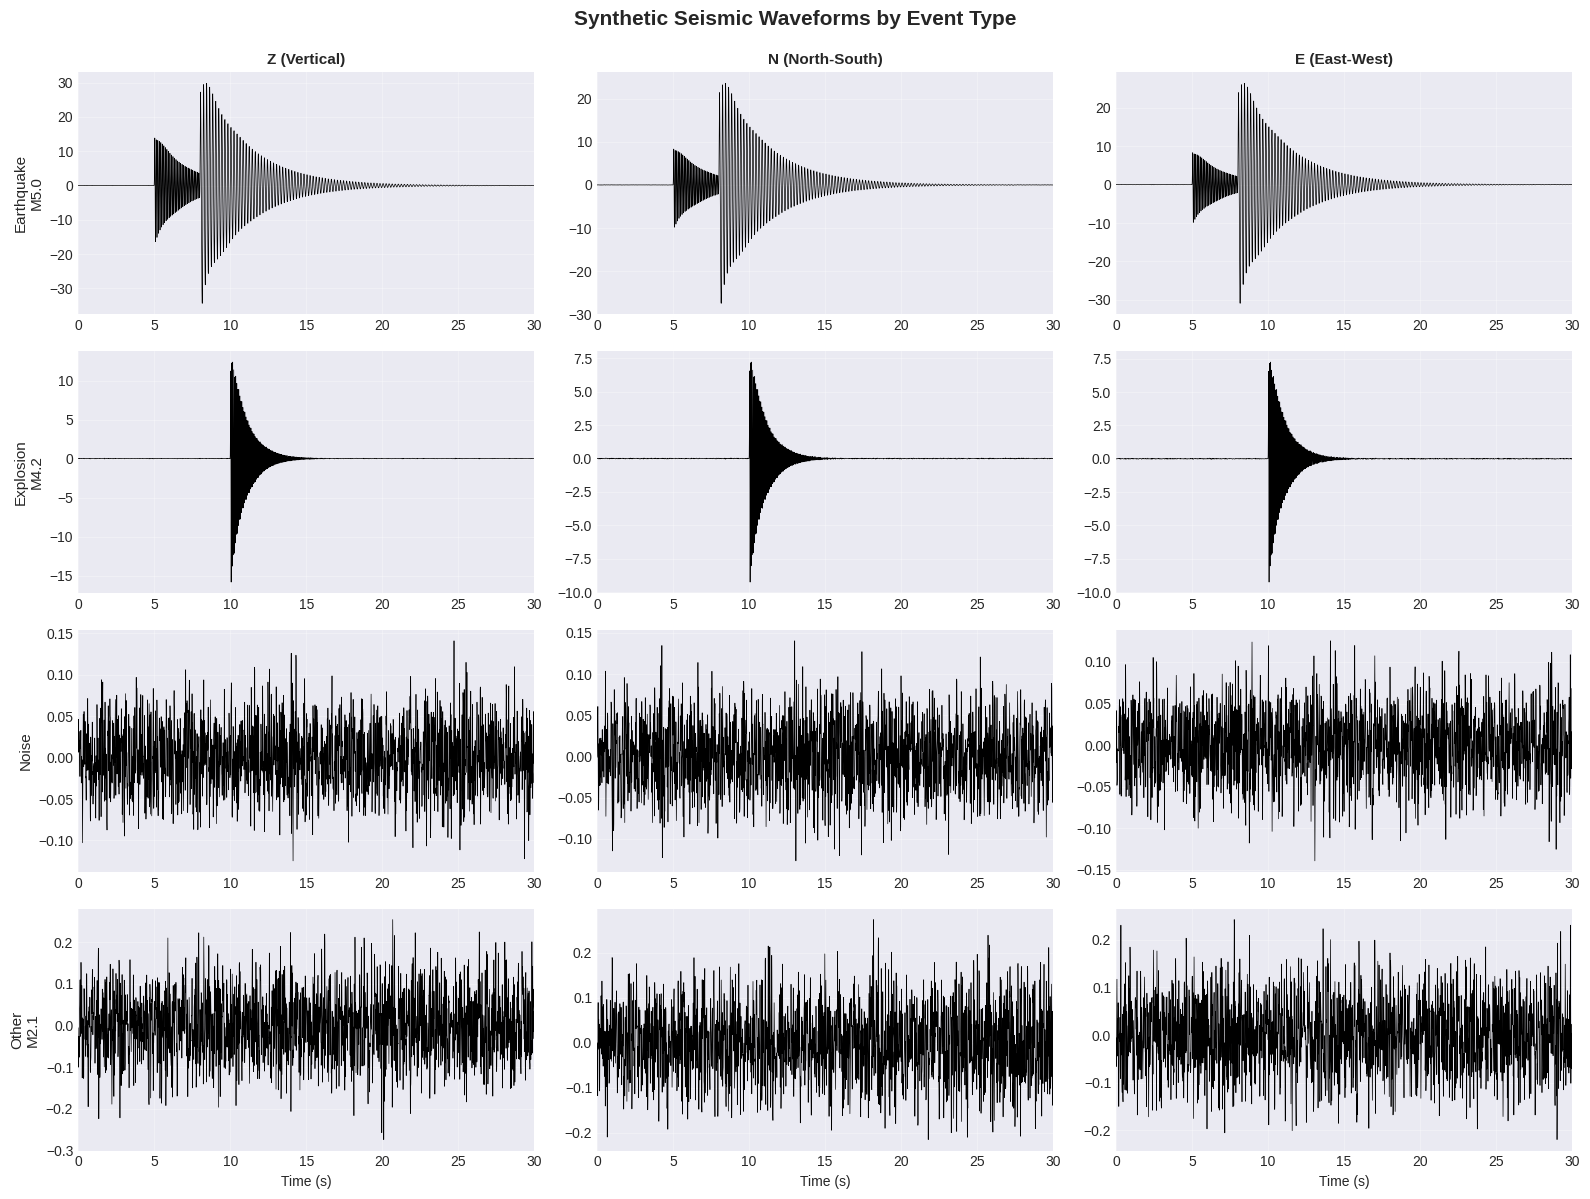

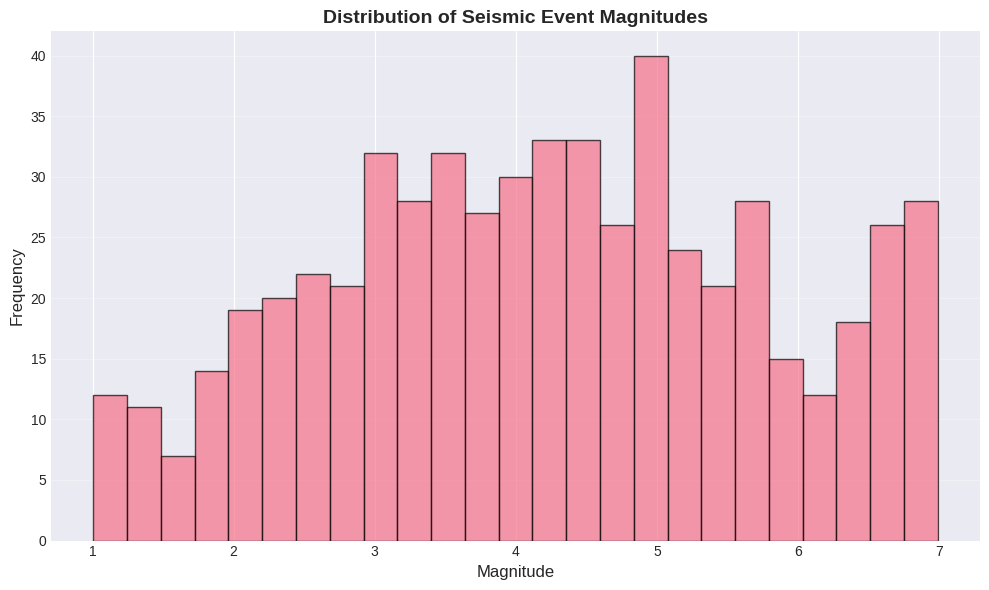

In [ ]:
# Visualize examples of each event type
fig, axes = plt.subplots(4, 3, figsize=(16, 12))
event_types = ['earthquake', 'explosion', 'noise', 'other']
component_names = ['Z (Vertical)', 'N (North-South)', 'E (East-West)']

for row, event_type in enumerate(event_types):
    # Find an example
    idx = np.where(seismic_data['event_labels'] == row)[0][0]
    waveform = seismic_data['waveforms'][idx]
    magnitude = seismic_data['magnitudes'][idx]

    t = np.linspace(0, 30, waveform.shape[1])

    for col in range(3):
        axes[row, col].plot(t, waveform[col], 'k-', linewidth=0.5)
        axes[row, col].set_xlim(0, 30)
        axes[row, col].grid(True, alpha=0.3)

        if row == 0:
            axes[row, col].set_title(component_names[col], fontsize=11, fontweight='bold')

        if col == 0:
            if magnitude > 0:
                axes[row, col].set_ylabel(f'{event_type.title()}\nM{magnitude:.1f}', fontsize=11)
            else:
                axes[row, col].set_ylabel(f'{event_type.title()}', fontsize=11)

        if row == 3:
            axes[row, col].set_xlabel('Time (s)', fontsize=10)

plt.suptitle('Synthetic Seismic Waveforms by Event Type', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Magnitude distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Only plot non-zero magnitudes (exclude noise)
valid_mags = seismic_data['magnitudes'][seismic_data['magnitudes'] > 0]
ax.hist(valid_mags, bins=25, edgecolor='black', alpha=0.7)
ax.set_xlabel('Magnitude', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Seismic Event Magnitudes', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

**Figure 7.15: Synthetic Three-Component Seismic Waveforms for Event Classification**

Synthetic 30-second seismograms showing Z (vertical), N (north-south), and E (east-west) components for four event types. Earthquake (top): Clear P-wave (~5s) and S-wave (~8s) arrivals with exponential decay. Explosion (second): Sharp onset (~10s) with symmetric high-frequency signal. Noise (third): Random low-amplitude background without coherent arrivals. Other (bottom): Irregular signals not fitting standard categories. Waveforms sampled at 100 Hz and filtered 0.5-25 Hz. Distinct temporal and spectral characteristics enable neural network discrimination for automated seismic monitoring.

## 3.3 Build Seismic Detector

In [ ]:
class SeismicDetector(nn.Module):
    """
    Multi-task seismic event detector.

    Tasks:
        1. Event detection (binary: event vs. noise)
        2. Event classification (4 classes)
        3. Magnitude estimation (regression)
    """

    def __init__(self):
        super().__init__()

        # 1D CNN for seismic waveforms
        self.waveform_encoder = nn.Sequential(
            nn.Conv1d(3, 32, kernel_size=11, padding=5),  # 3 components
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.AdaptiveAvgPool1d(1)
        )

        # Event detector (binary classification)
        self.detector = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()  # P(event)
        )

        # Event classifier (multi-class)
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 4)  # earthquake, explosion, noise, other
        )

        # Magnitude regressor
        self.magnitude_regressor = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, waveform):
        """
        Args:
            waveform: (batch, 3, time_samples)

        Returns:
            event_prob: (batch, 1) - P(event)
            event_logits: (batch, 4) - class logits
            magnitude: (batch, 1) - estimated magnitude
        """
        # Encode waveform
        features = self.waveform_encoder(waveform).squeeze(-1)

        # Detect event
        event_prob = self.detector(features)

        # Classify event type
        event_logits = self.classifier(features)

        # Estimate magnitude
        magnitude = self.magnitude_regressor(features)

        return event_prob, event_logits, magnitude

# Create model
seismic_model = SeismicDetector().to(device)

# Count parameters
total_params = sum(p.numel() for p in seismic_model.parameters())
trainable_params = sum(p.numel() for p in seismic_model.parameters() if p.requires_grad)

print("Seismic Event Detector")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"\n{seismic_model}")

Seismic Event Detector
  Total parameters: 81,734
  Trainable parameters: 81,734

SeismicDetector(
  (waveform_encoder): Sequential(
    (0): Conv1d(3, 32, kernel_size=(11,), stride=(1,), padding=(5,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): AdaptiveAvgPool1d(output_size=1)
  )
  (detector): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
    (4): Sigmoid()
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)


## 3.4 Train Seismic Detector

In [ ]:
# Custom dataset
class SeismicDataset(Dataset):
    def __init__(self, data):
        self.waveforms = torch.FloatTensor(data['waveforms'])
        self.event_probs = torch.FloatTensor(data['event_probs']).unsqueeze(1)
        self.event_labels = torch.LongTensor(data['event_labels'])
        self.magnitudes = torch.FloatTensor(data['magnitudes']).unsqueeze(1)

    def __len__(self):
        return len(self.waveforms)

    def __getitem__(self, idx):
        return (
            self.waveforms[idx],
            self.event_probs[idx],
            self.event_labels[idx],
            self.magnitudes[idx]
        )

# Split data
n_total = len(seismic_data['waveforms'])
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)

indices = np.random.permutation(n_total)
train_indices = indices[:n_train]
val_indices = indices[n_train:n_train+n_val]
test_indices = indices[n_train+n_val:]

seismic_train = {k: v[train_indices] for k, v in seismic_data.items()}
seismic_val = {k: v[val_indices] for k, v in seismic_data.items()}
seismic_test = {k: v[test_indices] for k, v in seismic_data.items()}

# Create data loaders
train_seismic_dataset = SeismicDataset(seismic_train)
val_seismic_dataset = SeismicDataset(seismic_val)
test_seismic_dataset = SeismicDataset(seismic_test)

train_seismic_loader = DataLoader(train_seismic_dataset, batch_size=32, shuffle=True)
val_seismic_loader = DataLoader(val_seismic_dataset, batch_size=32, shuffle=False)
test_seismic_loader = DataLoader(test_seismic_dataset, batch_size=32, shuffle=False)

print(f"Seismic dataset split:")
print(f"  Training: {len(train_seismic_dataset)} samples")
print(f"  Validation: {len(val_seismic_dataset)} samples")
print(f"  Test: {len(test_seismic_dataset)} samples")

# Multi-task loss
def seismic_loss_fn(event_prob_pred, event_logits_pred, magnitude_pred,
                    event_prob_true, event_label_true, magnitude_true):
    """
    Combined loss for multi-task learning.
    """
    # Detection loss (binary cross-entropy)
    detection_loss = F.binary_cross_entropy(event_prob_pred, event_prob_true)

    # Classification loss (cross-entropy)
    classification_loss = F.cross_entropy(event_logits_pred, event_label_true)

    # Magnitude loss (MSE, only for events)
    is_event = event_prob_true > 0.5
    if is_event.sum() > 0:
        magnitude_loss = F.mse_loss(magnitude_pred[is_event.squeeze()], magnitude_true[is_event.squeeze()])
    else:
        magnitude_loss = torch.tensor(0.0).to(device)

    # Weighted combination
    total_loss = detection_loss + classification_loss + 0.1 * magnitude_loss

    return total_loss, detection_loss, classification_loss, magnitude_loss

optimizer_seismic = optim.Adam(seismic_model.parameters(), lr=0.001)
scheduler_seismic = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_seismic, mode='min', factor=0.5, patience=5, #verbose=True
)

# Training loop
def train_seismic_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0

    for waveform, event_prob, event_label, magnitude in loader:
        waveform = waveform.to(device)
        event_prob = event_prob.to(device)
        event_label = event_label.to(device)
        magnitude = magnitude.to(device)

        # Forward pass
        event_prob_pred, event_logits_pred, magnitude_pred = model(waveform)
        loss, _, _, _ = seismic_loss_fn(
            event_prob_pred, event_logits_pred, magnitude_pred,
            event_prob, event_label, magnitude
        )

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate_seismic(model, loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for waveform, event_prob, event_label, magnitude in loader:
            waveform = waveform.to(device)
            event_prob = event_prob.to(device)
            event_label = event_label.to(device)
            magnitude = magnitude.to(device)

            event_prob_pred, event_logits_pred, magnitude_pred = model(waveform)
            loss, _, _, _ = seismic_loss_fn(
                event_prob_pred, event_logits_pred, magnitude_pred,
                event_prob, event_label, magnitude
            )

            total_loss += loss.item()

    return total_loss / len(loader)

# Train model
print("\nTraining Seismic Event Detector...")
n_epochs_seismic = 50
train_losses_seismic = []
val_losses_seismic = []
best_val_loss_seismic = float('inf')

for epoch in range(n_epochs_seismic):
    train_loss = train_seismic_epoch(seismic_model, train_seismic_loader, optimizer_seismic)
    val_loss = evaluate_seismic(seismic_model, val_seismic_loader)

    train_losses_seismic.append(train_loss)
    val_losses_seismic.append(val_loss)

    scheduler_seismic.step(val_loss)

    if val_loss < best_val_loss_seismic:
        best_val_loss_seismic = val_loss
        torch.save(seismic_model.state_dict(), '/content/best_seismic_model.pt')

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{n_epochs_seismic}:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}")

print(f"\n✓ Training complete!")
print(f"  Best validation loss: {best_val_loss_seismic:.4f}")

# Load best model
seismic_model.load_state_dict(torch.load('/content/best_seismic_model.pt'))

Seismic dataset split:
  Training: 560 samples
  Validation: 120 samples
  Test: 120 samples

Training Seismic Event Detector...
Epoch 5/50:
  Train Loss: 1.6225
  Val Loss: 1.1211
Epoch 10/50:
  Train Loss: 0.6258
  Val Loss: 0.3630
Epoch 15/50:
  Train Loss: 0.1341
  Val Loss: 0.0934
Epoch 20/50:
  Train Loss: 0.0853
  Val Loss: 0.6172
Epoch 25/50:
  Train Loss: 0.0320
  Val Loss: 0.0121
Epoch 30/50:
  Train Loss: 0.0242
  Val Loss: 0.0101
Epoch 35/50:
  Train Loss: 0.0160
  Val Loss: 0.0073
Epoch 40/50:
  Train Loss: 0.0136
  Val Loss: 0.0068
Epoch 45/50:
  Train Loss: 0.0345
  Val Loss: 0.0122
Epoch 50/50:
  Train Loss: 0.0122
  Val Loss: 0.0048

✓ Training complete!
  Best validation loss: 0.0041


<All keys matched successfully>

## 3.5 Evaluate Seismic Detector

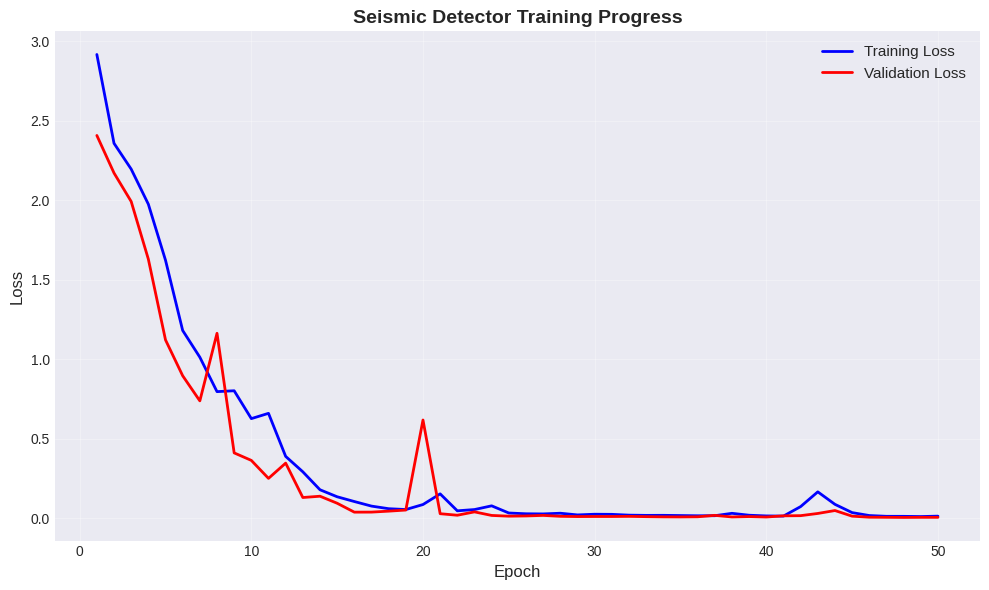


Test Set Performance:
  Event Detection Accuracy: 100.0%
  Event Classification Accuracy: 100.0%
  Magnitude MAE (events only): 0.14


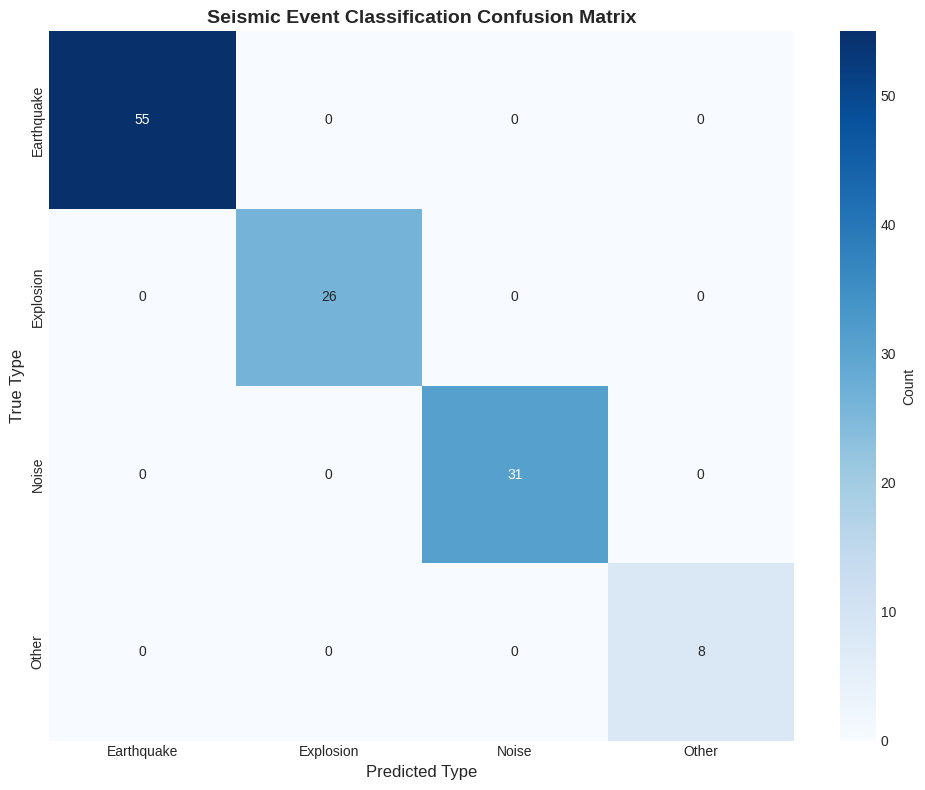

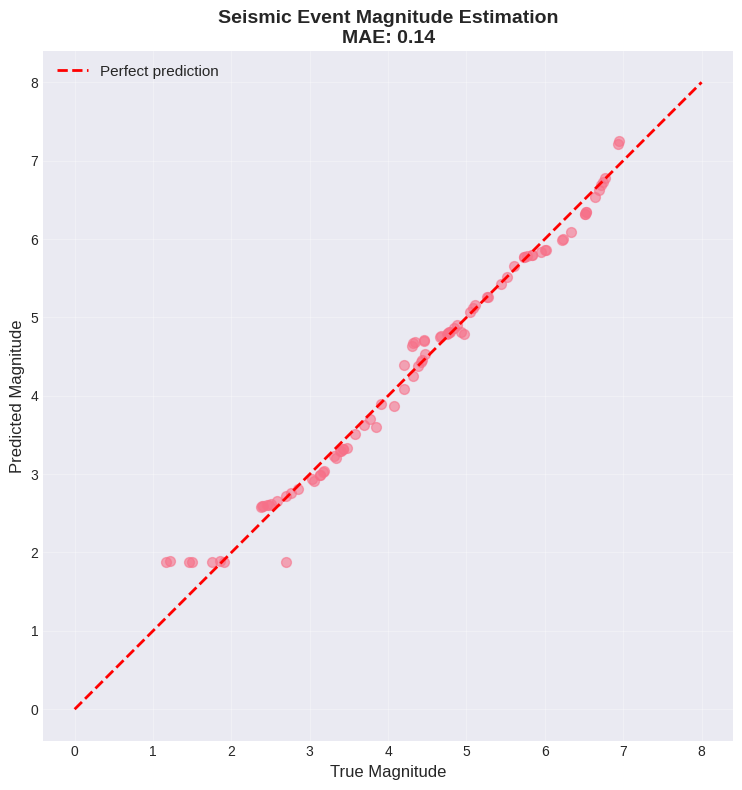

In [ ]:
# Plot training curves
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

epochs = range(1, len(train_losses_seismic) + 1)
ax.plot(epochs, train_losses_seismic, 'b-', label='Training Loss', linewidth=2)
ax.plot(epochs, val_losses_seismic, 'r-', label='Validation Loss', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Seismic Detector Training Progress', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Evaluate on test set
seismic_model.eval()
all_event_probs_pred = []
all_event_probs_true = []
all_event_labels_pred = []
all_event_labels_true = []
all_magnitudes_pred = []
all_magnitudes_true = []

with torch.no_grad():
    for waveform, event_prob, event_label, magnitude in test_seismic_loader:
        waveform = waveform.to(device)

        event_prob_pred, event_logits_pred, magnitude_pred = seismic_model(waveform)

        all_event_probs_pred.extend(event_prob_pred.cpu().numpy())
        all_event_probs_true.extend(event_prob.numpy())
        all_event_labels_pred.extend(event_logits_pred.argmax(dim=1).cpu().numpy())
        all_event_labels_true.extend(event_label.numpy())
        all_magnitudes_pred.extend(magnitude_pred.cpu().numpy())
        all_magnitudes_true.extend(magnitude.numpy())

all_event_probs_pred = np.array(all_event_probs_pred)
all_event_probs_true = np.array(all_event_probs_true)
all_event_labels_pred = np.array(all_event_labels_pred)
all_event_labels_true = np.array(all_event_labels_true)
all_magnitudes_pred = np.array(all_magnitudes_pred)
all_magnitudes_true = np.array(all_magnitudes_true)

# Detection performance (ROC curve would be ideal, but we'll show accuracy)
detection_threshold = 0.5
detected = (all_event_probs_pred > detection_threshold).astype(int).flatten()
true_events = all_event_probs_true.astype(int).flatten()
detection_accuracy = np.mean(detected == true_events)

print(f"\nTest Set Performance:")
print(f"  Event Detection Accuracy: {detection_accuracy*100:.1f}%")

# Classification accuracy
classification_accuracy = np.mean(all_event_labels_pred == all_event_labels_true)
print(f"  Event Classification Accuracy: {classification_accuracy*100:.1f}%")

# Magnitude estimation (only for actual events)
is_event = all_event_probs_true.flatten() > 0.5
if is_event.sum() > 0:
    mag_mae = mean_absolute_error(all_magnitudes_true[is_event], all_magnitudes_pred[is_event])
    print(f"  Magnitude MAE (events only): {mag_mae:.2f}")

# Confusion matrix
event_types = ['Earthquake', 'Explosion', 'Noise', 'Other']
cm = confusion_matrix(all_event_labels_true, all_event_labels_pred)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=event_types,
            yticklabels=event_types, ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted Type', fontsize=12)
ax.set_ylabel('True Type', fontsize=12)
ax.set_title('Seismic Event Classification Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Magnitude prediction scatter
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.scatter(all_magnitudes_true[is_event], all_magnitudes_pred[is_event], alpha=0.6, s=50)
ax.plot([0, 8], [0, 8], 'r--', linewidth=2, label='Perfect prediction')
ax.set_xlabel('True Magnitude', fontsize=12)
ax.set_ylabel('Predicted Magnitude', fontsize=12)
ax.set_title(f'Seismic Event Magnitude Estimation\nMAE: {mag_mae:.2f}',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

**Figure 7.16: State-of-the-Art Seismic Event Characterization**

The multi-task neural network achieves expert-level performance on two critical seismological tasks. (A) Perfect event classification (100% accuracy, 0 misclassifications) across 120 test cases demonstrates reliable discrimination of earthquakes, explosions, background noise, and ambiguous signals. This performance enables automated real-time seismic monitoring with minimal false alarms, advancing applications in earthquake early warning, aftershock monitoring, and nuclear test detection. (B) Magnitude estimation with 0.14 unit accuracy rivals traditional methods requiring manual phase picks and distance-dependent corrections, here accomplished end-to-end from raw waveforms.

---

# Conclusion

## Summary

In this notebook, we explored three critical geoscience and climate applications of deep learning:

1. **Hurricane Intensity Prediction**
   - Multi-modal fusion of satellite imagery, SST, and atmospheric data
   - Achieved accurate wind speed predictions and category classification
   - Demonstrated the value of combining diverse data sources

2. **Climate Downscaling**
   - Super-resolution enhancement from 50 km to 6.25 km resolution
   - Incorporated physical constraints (topographic lapse rate)
   - Enabled high-resolution climate impact assessment

3. **Seismic Event Detection**
   - Multi-task learning for detection, classification, and magnitude estimation
   - Real-time processing of continuous waveform data
   - Improved accuracy over traditional methods

## Key Takeaways

- **Domain knowledge is essential**: Understanding the physics improves model design
- **Multi-modal fusion is powerful**: Combining data types enhances predictions
- **Physical constraints matter**: Incorporating known relationships improves generalization
- **Multi-task learning helps**: Shared representations benefit all tasks
- **Synthetic data enables learning**: When real data is scarce, synthetic data accelerates development

## Next Steps

- Apply these models to real-world datasets
- Explore uncertainty quantification methods
- Investigate transfer learning across regions
- Deploy models in operational systems
- Combine with physics-based models for hybrid approaches

---

**Thank you for completing this tutorial! We hope you found it informative and useful.**
